In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataprep.eda import plot
import scipy
import scipy.cluster.hierarchy as sch
from dataprep.eda import plot as dpplot
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, GammaRegressor, TweedieRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ITSalarySurveyEU2020.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 23 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Timestamp                                                                                                                1253 non-null   object 
 1   Age                                                                                                                      1226 non-null   float64
 2   Gender                                                                                                                   1243 non-null   object 
 3   City                                                                                                                     1253 non-null   o

In [4]:
df.describe(include='all').T

count unique  \
Timestamp                                             1253   1248   
Age                                                 1226.0    NaN   
Gender                                                1243      3   
City                                                  1253    119   
Position                                              1247    148   
Total years of experience                             1237     48   
Years of experience in Germany                        1221     53   
Seniority level                                       1241     24   
Your main technology / programming language           1126    256   
Other technologies/programming languages you us...    1096    562   
Yearly brutto salary (without bonus and stocks)...  1253.0    NaN   
Yearly bonus + stocks in EUR                           829    168   
Annual brutto salary (without bonus and stocks)...   885.0    NaN   
Annual bonus+stocks one year ago. Only answer i...     614    131   
Number of vacation days                               1185     45   
Employment status                                     1236     11   
Сontract duration                                     1224      3   
Main language at work                                 1237     14   
Company size                                          1235      5   
Company type                                          1228     63   
Have you lost your job due to the coronavirus o...    1233     10   
Have you been forced to have a shorter working ...   373.0    NaN   
Have you received additional monetary support f...     462     59   

                                                                        top  \
Timestamp                                               25/11/2020 08:47:37   
Age                                                                     NaN   
Gender                                                                 Male   
City                                                                 Berlin   
Position                                                  Software Engineer   
Total years of experience                                                10   
Years of experience in Germany                                            2   
Seniority level                                                      Senior   
Your main technology / programming language                            Java   
Other technologies/programming languages you us...  Javascript / Typescript   
Yearly brutto salary (without bonus and stocks)...                      NaN   
Yearly bonus + stocks in EUR                                              0   
Annual brutto salary (without bonus and stocks)...                      NaN   
Annual bonus+stocks one year ago. Only answer i...                        0   
Number of vacation days                                                  30   
Employment status                                        Full-time employee   
Сontract duration                                        Unlimited contract   
Main language at work                                               English   
Company size                                                          1000+   
Company type                                                        Product   
Have you lost your job due to the coronavirus o...                       No   
Have you been forced to have a shorter working ...                      NaN   
Have you received additional monetary support f...                        0   

                                                    freq             mean  \
Timestamp                                              2              NaN   
Age                                                  NaN        32.509788   
Gender                                              1049              NaN   
City                                                 681              NaN   
Position                                             387              NaN   
Total years of experience            

In [5]:
df.select_dtypes('object').columns

Index(['Timestamp', 'Gender', 'City', 'Position ', 'Total years of experience',
       'Years of experience in Germany', 'Seniority level',
       'Your main technology / programming language',
       'Other technologies/programming languages you use often',
       'Yearly bonus + stocks in EUR',
       'Annual bonus+stocks one year ago. Only answer if staying in same country',
       'Number of vacation days', 'Employment status', 'Сontract duration',
       'Main language at work', 'Company size', 'Company type',
       'Have you lost your job due to the coronavirus outbreak?',
       'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'],
      dtype='object')

In [6]:
df['Total years of experience'] = df['Total years of experience'].str.replace(',', '.')
df['Years of experience in Germany'] = df['Years of experience in Germany'].str.replace(',', '.')
df['Number of vacation days'] = df['Number of vacation days'].str.replace(',', '.')

In [7]:
df.loc[df['Total years of experience'].str.contains(r'[A-Za-z<⁰~\+\- ]+').fillna(False), 'Total years of experience']

805                      1 (as QA Engineer) / 11 in total
855                                  15. thereof 8 as CTO
1089    6 (not as a data scientist. but as a lab scien...
1209                                       less than year
Name: Total years of experience, dtype: object

In [8]:
df.loc[805, 'Total years of experience'] = '11'
df.loc[855, 'Total years of experience'] = '15'
df.loc[1089, 'Total years of experience'] = '6'
df.loc[1209, 'Total years of experience'] = '0'

In [9]:
df.loc[df['Years of experience in Germany'].str.contains(r'[A-Za-z<⁰~\+\- ]+').fillna(False), 'Years of experience in Germany']

343                                                   < 1
392                    4 (in Switzerland). 0 (in Germany)
618                                               4 month
750                                              3 months
847                                         3 (in Poland)
867                                                    <1
883                                                     ⁰
1052                                                    -
1089    6 (not as a data scientist. but as a lab scien...
1209                                       less than year
Name: Years of experience in Germany, dtype: object

In [10]:
df.loc[343, 'Years of experience in Germany'] = '0'
df.loc[392, 'Years of experience in Germany'] = '0'
df.loc[618, 'Years of experience in Germany'] = '0'
df.loc[750, 'Years of experience in Germany'] = '0'
df.loc[847, 'Years of experience in Germany'] = '0'
df.loc[867, 'Years of experience in Germany'] = '0'
df.loc[883, 'Years of experience in Germany'] = '0'
df.loc[1089, 'Years of experience in Germany'] = '6'
df.loc[1209, 'Years of experience in Germany'] = '0'
df['Years of experience in Germany'] = df['Years of experience in Germany'].replace('-', np.nan)

In [11]:
df.loc[df['Number of vacation days'].str.contains(r'[A-Za-z<⁰~\+\- ]+').fillna(False), 'Number of vacation days']

324                                        unlimited
368                                       unlimited 
404                                        (no idea)
432     30 in contract (but theoretically unlimited)
534                                       Unlimited 
664                                              ~25
771                                        unlimited
792                                              23+
911                                        Unlimited
938                                   24 labour days
948                                        Unlimited
961                                        unlimited
1249                                      unlimited 
Name: Number of vacation days, dtype: object

In [12]:
df['Number of vacation days'] = df['Number of vacation days'].replace('(no idea)', np.nan)
df['Number of vacation days'] = df['Number of vacation days'].str.replace('unlimited', '365')
df['Number of vacation days'] = df['Number of vacation days'].str.replace('Unlimited', '365')
df.loc[432, 'Number of vacation days'] = '30'
df.loc[664, 'Number of vacation days'] = '25'
df.loc[792, 'Number of vacation days'] = '23'
df.loc[938, 'Number of vacation days'] = '24'

In [13]:
df[['Total years of experience', 'Years of experience in Germany', 'Number of vacation days']] = df[['Total years of experience', 'Years of experience in Germany', 'Number of vacation days']].astype('float')

In [14]:
df.query('`Total years of experience` > 30 or `Years of experience in Germany` > 30 or `Number of vacation days` > 180')[['Total years of experience', 'Years of experience in Germany', 'Number of vacation days']]

Total years of experience  Years of experience in Germany  \
59                         40.0                             4.0   
235                         9.0                             5.0   
324                        11.0                             4.0   
368                        11.0                             1.0   
534                         4.0                             2.0   
771                        19.0                             7.0   
911                        12.0                             6.0   
948                        10.0                             2.0   
955                        31.0                             6.0   
961                         4.0                             4.0   
1103                      383.0                             3.0   
1249                       10.0                             1.5   

      Number of vacation days  
59                       30.0  
235                     365.0  
324                     365.0  
368                     365.0  
534                     365.0  
771                     365.0  
911                     365.0  
948                     365.0  
955                      29.0  
961                     365.0  
1103                      NaN  
1249                    365.0

In [15]:
df['Total years of experience'] = df['Total years of experience'].mask(df['Total years of experience']==383.0)

In [16]:
df.query('`Yearly brutto salary (without bonus and stocks) in EUR` > 999999')

Timestamp   Age  Gender     City    Position   \
473  25/11/2020 03:27:34   NaN     NaN   Berlin          NaN   
853  27/11/2020 14:55:13  29.0  Female  Cologne  ML Engineer   

     Total years of experience  Years of experience in Germany  \
473                        NaN                             NaN   
853                        1.0                             1.0   

    Seniority level Your main technology / programming language  \
473             NaN                                         NaN   
853          Middle                                       julia   

    Other technologies/programming languages you use often  ...  \
473                                                NaN      ...   
853                                                NaN      ...   

     Annual bonus+stocks one year ago. Only answer if staying in same country  \
473                                                NaN                          
853                                           50000000                          

    Number of vacation days   Employment status   Сontract duration  \
473                     NaN                 NaN                 NaN   
853                    99.0  Full-time employee  Unlimited contract   

     Main language at work Company size Company type  \
473                    NaN          NaN          NaN   
853                English     up to 10      Startup   

    Have you lost your job due to the coronavirus outbreak?  \
473                                                NaN        
853                                                 No        

    Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week  \
473                                                NaN                                                  
853                                                0.0                                                  

    Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR  
473                                                NaN                                                                       
853                                                  0                                                                       

[2 rows x 23 columns]

In [17]:
df.drop(df.query('`Yearly brutto salary (without bonus and stocks) in EUR` > 999999').index, axis=0, inplace=True)

In [18]:
df.drop(['Timestamp', 'Yearly bonus + stocks in EUR', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country', 'Annual bonus+stocks one year ago. Only answer if staying in same country', 'Have you lost your job due to the coronavirus outbreak?', 'Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week', 'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'], axis=1, inplace=True)

In [19]:
df['Gender'].value_counts()

Male       1049
Female      191
Diverse       2
Name: Gender, dtype: int64

In [20]:
df['Gender'].isna().sum()

9

In [21]:
df['Gender'] = df['Gender'].replace('Diverse', np.nan)

In [22]:
df['City'].value_counts().nlargest(25)

Berlin         680
Munich         236
Frankfurt       44
Hamburg         40
Stuttgart       26
Cologne         19
Amsterdam        9
Stuttgart        7
Moscow           6
Düsseldorf       6
Prague           6
Karlsruhe        6
Stockholm        5
London           5
Zurich           5
Düsseldorf       4
Heidelberg       4
Nürnberg         4
Helsinki         4
Rome             3
Bonn             3
Mannheim         3
Dusseldorf       3
Tallinn          3
Hannover         3
Name: City, dtype: int64

In [23]:
germany = ['Munich', 'Berlin', 'Hamburg', 'Wolfsburg', 'Stuttgart', 'Schleswig-Holstein', 'Konstanz area', 'Frankfurt', 'Cologne', 'Kempten', 'Münster', 'Erlangen', 'Rosenheim', 'Mannheim ', 'Boeblingen', 'Düsseldorf', 'Ingolstadt', 'Nürnberg', 'Ansbach', 'Leipzig', 'Mannheim', 'Tuttlingen', 'Bonn', 'Koblenz', 'Heidelberg', 'Karlsruhe', 'Köln', 'Aachen', 'Karlsruhe ', 'Dusseldorf', 'Würzburg', 'Braunschweig ', 'Dresden', 'Stuttgart ', 'Lübeck', 'Nuremberg ', 'Bodensee', 'Paderborn', 'Konstanz', 'Ulm', 'Düsseldorf ', 'Bölingen', 'Hannover', 'Siegen', 'Nuremberg', 'Friedrichshafen', 'Walldorf', 'Regensburg', 'Heilbronn', 'Dortmund', 'Bielefeld', 'Hildesheim', 'Heidelberg ', 'Murnau am Staffelsee ', 'Hildesheim ', 'Dusseldurf', 'Darmstadt', 'Duesseldorf', 'Sevilla', 'Ingolstadt ', 'Saarbrücken']
europe = ['London', 'Vienna', 'Moldova', 'Moscow', 'Warsaw', 'Samara', 'Riga, Latvia', 'Zurich', 'Helsinki', 'Kiev', 'Den Haag', 'Amsterdam', 'Cracovia', 'Tallinn', 'Prague', 'Utrecht', 'Stockholm', 'Kyiv', 'Malta', 'Milan', 'Salzburg', 'Rome', 'Wroclaw', 'Paris', 'Dublin ', 'Barcelona', 'Tampere (Finland)', 'Bucharest', 'Minsk', 'Marseille', 'Eindhoven', 'France', 'Warsaw, Poland', 'Jena', 'City in Russia', 'Cracow', 'Brunswick', 'Dublin', 'Madrid', 'Lisbon', 'Sofia', 'Luttich', 'Milano', 'Basel', 'Istanbul', 'warsaw', 'Zürich', 'Innsbruck', 'Brussels ', 'Fr', 'Cambridge', 'Brussels', 'Copenhagen', 'Sevilla', 'Krakow', 'Saint-Petersburg']

def create_region(x):
    if x in germany:
        return 'Germany'
    elif x in europe:
        return 'Europe'
    else:
        return 'Elsewhere'
    
df['Region'] = df['City'].apply(create_region)
df.head()

Age Gender    City           Position   Total years of experience  \
0  26.0   Male  Munich   Software Engineer                        5.0   
1  26.0   Male  Berlin   Backend Developer                        7.0   
2  29.0   Male  Berlin   Software Engineer                       12.0   
3  28.0   Male  Berlin  Frontend Developer                        4.0   
4  37.0   Male  Berlin   Backend Developer                       17.0   

   Years of experience in Germany Seniority level  \
0                             3.0          Senior   
1                             4.0          Senior   
2                             6.0            Lead   
3                             1.0          Junior   
4                             6.0          Senior   

  Your main technology / programming language  \
0                                  TypeScript   
1                                        Ruby   
2                     Javascript / Typescript   
3                                  Javascript   
4                                     C# .NET   

  Other technologies/programming languages you use often  \
0                    Kotlin, Javascript / Typescript       
1                                                NaN       
2                    Javascript / Typescript, Docker       
3                                                NaN       
4                             .NET, SQL, AWS, Docker       

   Yearly brutto salary (without bonus and stocks) in EUR  \
0                                            80000.0        
1                                            80000.0        
2                                           120000.0        
3                                            54000.0        
4                                            62000.0        

   Number of vacation days           Employment status   Сontract duration  \
0                     30.0          Full-time employee  Unlimited contract   
1                     28.0          Full-time employee  Unlimited contract   
2                     30.0  Self-employed (freelancer)  Temporary contract   
3                     24.0          Full-time employee  Unlimited contract   
4                     29.0          Full-time employee  Unlimited contract   

  Main language at work Company size Company type   Region  
0               English       51-100      Product  Germany  
1               English     101-1000      Product  Germany  
2               English     101-1000      Product  Germany  
3               English       51-100      Startup  Germany  
4               English     101-1000      Product  Germany

In [24]:
df['City'] = df['City'].mask(~df['City'].isin(['Berlin', 'Munich', 'Frankfurt', 'Hamburg',]),'Other Cities')
df['City'].value_counts().nlargest()

Berlin          680
Other Cities    251
Munich          236
Frankfurt        44
Hamburg          40
Name: City, dtype: int64

In [25]:
df['Position '].value_counts().nlargest(30)

Software Engineer      387
Backend Developer      174
Data Scientist         110
Frontend Developer      89
QA Engineer             71
DevOps                  57
Mobile Developer        53
ML Engineer             41
Product Manager         39
Data Engineer           25
Designer (UI/UX)        16
Engineering Manager     10
Data Analyst             8
CTO                      5
Fullstack Developer      4
SRE                      4
Project Manager          4
Software Architect       4
Team Lead                3
Consultant               3
Hardware Engineer        3
Business Analyst         3
Security Engineer        2
Head of Engineering      2
Product Analyst          2
IT Manager               2
Solutions Architect      2
Data Analyst             2
Support Engineer         2
Technical Lead           1
Name: Position , dtype: int64

In [26]:
mapper = {'Development': ['Software Engineer', 'Backend Developer', 'Frontend Developer', 'DevOps', 'Designer (UI/UX)', 'Mobile Developer', 'Software Architect', 'Test manager', 'QA Engineer', 'Hardware Engineer', 'Engineering Manager', 'Reporting Engineer', 'agile master ', 'Solution Architect', 'Fullstack Developer', 'Cloud Architect', 'Network Engineer ', 'Agile Coach', 'Scrum Master', 'Firmware Engineer', 'Solutions Architect', 'C/C++/Java developer', 'DevOps Manager', 'Security Manager', 'Graphic Designer', 'iOS Developer', 'Cloud Engineer', 'Solutions architect', 'Security Engineer', 'Support Engineer', 'Testautomation', 'SAP Developer', 'SW Architect', 'Fullstack engineer, ну или Software engineer', 'Senior Network&Security Eng.', 'Software tester ', 'QA Manager ', 'Software Developer in Test', 'Presales Engineer ', 'Engineering manager', 'Embedded Software Engineer', 'working student (QA)', 'Senior Scrum Master (RTE)', 'support engineer', 'Security engineer', 'XR Developer', 'Student, Software Developer, Data Engineer', 'Staff Engineer', 'Full-Stack Developer', 'QA Manager', 'Software Architekt', 'Testmanager'],
          'Data': ['Data Engineer', 'Data Scientist', 'Analytics engineer', 'ML Engineer', 'BI Consultant', 'Data Science Manager', 'Consultant Data Analytics', 'BI IT Consultant', 'DB developer/Data analyst', 'Business Analyst', 'DBA', 'Marketing Analyst', 'Data Analyst', 'Freelance AI lead / advisor', 'Researcher', 'Dana Analyst', 'Data Analyst ', 'BI Consultant SAP/ Data Engineer', 'computer vision researcher', 'Senior Data Engineer', 'Analyst', 'data engineer', 'BI Analyst ', 'BI Developer / Data Engineer', 'Big Data Engineer', 'AI Management', 'Data analyst ', 'Computational linguist', 'technical business analyst', 'Robotics Engineer', 'DatabEngineer', 'Researcher/ Consumer Insights Analyst '],
          'Other': ['Product Manager', 'Mobile Developer', 'Team Lead', 'Localization producer', 'Account Managet', 'System Administrator', 'Project Manager', 'VP Engineering', 'Data Center Manager', 'Tech Lead', 'Network Administrator', 'Banker', 'Stuttgart', 'Senior Program Manager', 'Consultant', 'Recruiter', 'Systemadministrator', 'SRE', 'HiWi', 'Project manager', 'Architect', 'Technical Lead', 'Tech Lead / Full-Stack', 'CTO', 'SAP BW Senior Consultant ', 'Director of Engineering', 'IT Spezialist', 'Manager', 'Consultant ', 'Technical account manager ', 'Tech Leader', 'Chief Research Officer', 'Business Development Manager Operations ', 'Program Manager', 'Team Manager', 'working student (QA)', 'Architect ', 'Head of Engineering', 'SAP Consultant', 'Teamlead', 'IT Manager', 'Head of IT ', 'Lead Software Developer', 'Tech recruiting', 'Head of BI', 'Technical project manager', 'Project manager ', 'Manager ', 'Professor', 'XR Developer', 'Student, Software Developer, Data Engineer', 'Engineering Team Lead', 'DataOps Team Lead', 'Software Sales', 'Beikoch', 'Product Management Praktikant', 'Product Analyst', 'Team lead', 'It Consulting ', 'Data architect', 'Head of IT', 'Rentner', 'QA Lead', 'Application Consultant', 'Lead Developer', 'ERP Consultant', 'IT Operations Manager']
         }
def create_dept(x):
    if x in mapper['Development']:
        return 'Development'
    elif x in mapper['Data']:
        return 'Data'
    elif x in mapper['Other']:
        return 'Other'
    
df['Department'] = df['Position '].apply(create_dept)
df.head()

Age Gender    City           Position   Total years of experience  \
0  26.0   Male  Munich   Software Engineer                        5.0   
1  26.0   Male  Berlin   Backend Developer                        7.0   
2  29.0   Male  Berlin   Software Engineer                       12.0   
3  28.0   Male  Berlin  Frontend Developer                        4.0   
4  37.0   Male  Berlin   Backend Developer                       17.0   

   Years of experience in Germany Seniority level  \
0                             3.0          Senior   
1                             4.0          Senior   
2                             6.0            Lead   
3                             1.0          Junior   
4                             6.0          Senior   

  Your main technology / programming language  \
0                                  TypeScript   
1                                        Ruby   
2                     Javascript / Typescript   
3                                  Javascript   
4                                     C# .NET   

  Other technologies/programming languages you use often  \
0                    Kotlin, Javascript / Typescript       
1                                                NaN       
2                    Javascript / Typescript, Docker       
3                                                NaN       
4                             .NET, SQL, AWS, Docker       

   Yearly brutto salary (without bonus and stocks) in EUR  \
0                                            80000.0        
1                                            80000.0        
2                                           120000.0        
3                                            54000.0        
4                                            62000.0        

   Number of vacation days           Employment status   Сontract duration  \
0                     30.0          Full-time employee  Unlimited contract   
1                     28.0          Full-time employee  Unlimited contract   
2                     30.0  Self-employed (freelancer)  Temporary contract   
3                     24.0          Full-time employee  Unlimited contract   
4                     29.0          Full-time employee  Unlimited contract   

  Main language at work Company size Company type   Region   Department  
0               English       51-100      Product  Germany  Development  
1               English     101-1000      Product  Germany  Development  
2               English     101-1000      Product  Germany  Development  
3               English       51-100      Startup  Germany  Development  
4               English     101-1000      Product  Germany  Development

In [27]:
df['Position '] = df['Position '].mask(~df['Position '].isin(['Software Engineer', 'Backend Developer', 'Data Scientist', 'Frontend Developer', 'QA Engineer', 'DevOps', 'Mobile Developer', 'ML Engineer', 'Product Manager', 'Data Engineer', 'Designer (UI/UX)', 'Engineering Manager']), 'Other Positions')

In [28]:
df['Seniority level'].value_counts().nlargest(30)

Senior                                       565
Middle                                       365
Lead                                         166
Junior                                        79
Head                                          44
Principal                                      3
Intern                                         1
Student                                        1
Working Student                                1
no idea, there are no ranges in the firm       1
CTO                                            1
Work Center Manager                            1
Self employed                                  1
VP                                             1
No level                                       1
Director                                       1
C-level executive manager                      1
Manager                                        1
C-Level                                        1
intern                                         1
Entry level         

In [29]:
df['Seniority level'] = df['Seniority level'].mask(~df['Seniority level'].isin(['Senior', 'Middle', 'Lead', 'Junior', 'Head' ]),'Others')
df['Seniority level'].value_counts().nlargest(10)

Senior    565
Middle    365
Lead      166
Junior     79
Head       44
Others     32
Name: Seniority level, dtype: int64

In [30]:
df['Other technologies/programming languages you use often'].value_counts().nlargest(30)

Javascript / Typescript                      44
Python                                       37
SQL                                          31
AWS, Docker                                  16
Kotlin                                       15
Python, SQL                                  13
Swift                                        13
C/C++                                        13
Javascript / Typescript, SQL, AWS, Docker    12
Python, C/C++                                11
Kotlin, Java / Scala                         10
PHP                                           9
Java / Scala                                  9
.NET                                          9
Python, C/C++, Docker                         9
SQL, AWS, Docker                              8
Java / Scala, SQL                             8
Python, SQL, AWS, Kubernetes, Docker          8
Kubernetes, Docker                            7
Javascript / Typescript, SQL, Docker          7
Javascript / Typescript, SQL            

In [31]:
onehot_df = df['Other technologies/programming languages you use often'].str.strip().str.split(', ').explode().str.title() \
.to_frame().assign(count=1).pivot(columns='Other technologies/programming languages you use often', values='count') \
.fillna(0).drop(np.nan, axis=1)
df = pd.concat([df, onehot_df], axis = 1)
df.drop('Other technologies/programming languages you use often', axis=1, inplace=True)

In [32]:
df['Your main technology / programming language'].value_counts().nlargest(30)

Java                       184
Python                     164
PHP                         56
C++                         38
JavaScript                  34
Javascript                  31
C#                          30
python                      26
Scala                       24
Swift                       24
Go                          23
Kotlin                      22
Python                      21
Ruby                        19
SQL                         14
TypeScript                  14
.NET                        13
JS                          12
iOS                         10
C                           10
R                            9
java                         9
javascript                   8
Android                      8
php                          8
Typescript                   8
Kubernetes                   7
.net                         7
Javascript / Typescript      6
JavaScript                   6
Name: Your main technology / programming language, dtype: int64

In [33]:
languages = {'JavaScript / TypeScript': ['TypeScript', 'Javascript / Typescript', 'Javascript', 'Typescript', 'NodeJS', 'JavaScript', 'JavaScript/ES6', 'Js', 'JavaScript ', 'JavaScript/TypeScript', 'JS', 'TypeScript, JavaScript', 'Node.js', 'Angular', 'Js, TypeScript, Angular', 'PS, Sketch, React, CSS3', 'Javascript ', 'Angular, React', 'React', 'NodeJS, Typescript, AWS', 'Typescript / Angular', 'React/Typescript', 'javascript', 'JavaScript/Typescript', 'TypeScript, React', 'JavaScript / typescript', 'typescript', 'Typescript, Web apps', 'React ', 'Nodejs', 'TS', 'js', 'Frontend: react, node.js', 'JavaScript / TypeScript', 'Kubrrnetes', 'Js, reactJS ', 'JS, WDIO', 'React JS', 'Typescript ', 'TypeScript/Angular', 'Angular, Typescript', 'React / JavaScript', 'JavScript', 'Javascript, Angular', 'Node', 'TypeScript, Kotlin', 'Qml', 'JavaScript, TypeScript', 'NodeJS/TS', 'Angular, TypeScript', 'NodsJs', 'Javascript/Typescript', 'JS, Java', 'React.js / TypeScript'],
             'C': ['C# .NET', 'C++', 'С#', 'C#', 'C#, .net core', 'C', 'C++, Java, Embedded C', 'c#', 'c++', 'Objective-C', 'C++/C#', 'C#/.NET', 'C/C++', 'C, C++', 'C++/c', 'Swift, Objective-C', '.net, c++, spss, embeddded', 'Swift, Objective-C, iOS', 'Swift, objective-c', 'Pascal, VB.NET, C#', 'C, Matlab', 'Embedded C++', 'c/c++', 'C++, C#', 'Ruby', 'ruby on rails', 'Ruby on Rails', 'PHP', 'Go', 'Go/Python', 'Php', 'PHP ', 'php', 'Golang', 'go', 'Golang ', 'Go, PHP, SQL', 'golang', 'Perl', 'php, js, python, docker', 'PHP/MySQL', 'Magento'],
             'Python': ['AWS, GCP, Python,K8s', 'Python', 'python', 'Ml/Python', 'Python ', 'SAS,SQL,Python', 'Python / JavaScript (React)', 'Python + SQL', 'Python, statistics, SQL', 'Python, SQL', 'VB, RPA, Python', 'pythin', 'Pyrhon', 'python ', 'Python, cloud computing ', 'Python (Django)', 'python, scala', 'Django, Flask, Plotly Dash', 'Python/SQL', 'NLP, Python', 'Python, Whole Apache Data Science Stack, AWS', 'Python, Pytorch', 'Python/NLP', 'Python, database technologies'],
             'Java': ['Java', 'java', 'Scala', 'Scala, React.js', 'Java, JavaScript', 'Java ', 'Java, angular, Aws', 'Java, Javascript', 'Java, terraform', 'Java, JS', 'Java/Kotlin', 'Java/C++', 'Scala / Python', 'Java/Scala', 'JAVA', 'Apache Spark', 'Java/Groovy', 'Terraform ', 'Java, .Net', 'Java, Kotlin', 'java/scala/go/clouds/devops', 'Spark', 'Terraform, Kubernetes, AWS, GCP, Ansible, Puppet', 'Java & PHP', 'Java & Distributed Systems Stuff', 'Spark, Pytorch', 'Scala, Apache Spark', 'scala', 'Java / Scala', 'Java Backend', 'spark', 'Kotlin', 'kotlin', 'Kotlin ', 'Kotlin, Java', 'Android/Kotlin', 'Kotlin/PHP', 'Swift/Kotlin'],
             'Cloud based': [ 'Aws Hadoop Postgre Typescript', 'Kubernetes', 'Google Cloud Platform', 'Cloud', 'DC Management', 'Network', 'Computer Networking,  Network Security ', 'AWS', 'k8s', 'Kubrrnetes', 'networking, linux, automation, cloud', 'Kubernetes, Terraform, GCP', 'Kuberenetes, Openstack', 'GCP']
            }

def create_languages(x):
    if x in languages['JavaScript / TypeScript']:
        return 'JavaScript / TypeScript'
    elif x in languages['C']:
        return 'C'
    elif x in languages['Python']:
        return 'Python'
    elif x in languages['Java']:
        return 'Java'
    elif x in languages['Cloud based']:
        return 'Cloud Based'
    else:
        return 'Other Languages'
    
df['Your main technology / programming language'] = df['Your main technology / programming language'].apply(create_languages)
df.head()

Age Gender    City           Position   Total years of experience  \
0  26.0   Male  Munich   Software Engineer                        5.0   
1  26.0   Male  Berlin   Backend Developer                        7.0   
2  29.0   Male  Berlin   Software Engineer                       12.0   
3  28.0   Male  Berlin  Frontend Developer                        4.0   
4  37.0   Male  Berlin   Backend Developer                       17.0   

   Years of experience in Germany Seniority level  \
0                             3.0          Senior   
1                             4.0          Senior   
2                             6.0            Lead   
3                             1.0          Junior   
4                             6.0          Senior   

  Your main technology / programming language  \
0                     JavaScript / TypeScript   
1                                           C   
2                     JavaScript / TypeScript   
3                     JavaScript / TypeScript   
4                                           C   

   Yearly brutto salary (without bonus and stocks) in EUR  \
0                                            80000.0        
1                                            80000.0        
2                                           120000.0        
3                                            54000.0        
4                                            62000.0        

   Number of vacation days  ...  Sql Squish Swift Tailwindcss Tensorflow  \
0                     30.0  ...  0.0    0.0   0.0         0.0        0.0   
1                     28.0  ...  0.0    0.0   0.0         0.0        0.0   
2                     30.0  ...  0.0    0.0   0.0         0.0        0.0   
3                     24.0  ...  0.0    0.0   0.0         0.0        0.0   
4                     29.0  ...  1.0    0.0   0.0         0.0        0.0   

  Terraform Theano  Unix Shell Scripts  Vba  Vms  
0       0.0    0.0                 0.0  0.0  0.0  
1       0.0    0.0                 0.0  0.0  0.0  
2       0.0    0.0                 0.0  0.0  0.0  
3       0.0    0.0                 0.0  0.0  0.0  
4       0.0    0.0                 0.0  0.0  0.0  

[5 rows x 108 columns]

In [34]:
df['Company type'].value_counts().nlargest(30)

Product                   760
Startup                   251
Consulting / Agency       142
Bank                        5
Media                       3
E-commerce                  3
Fintech                     2
Utilities                   2
Research                    2
University                  2
Corporation                 2
Finance                     2
Ecommerce                   1
eCommerce                   1
Handel                      1
Research institute          1
Bloody enterprise           1
Market Research             1
Corporation                 1
FAANG                       1
Bank                        1
freelance                   1
Semiconductor               1
Consulting and Product      1
Old industry                1
Personal Ltd                1
Industry                    1
Construction                1
Telecommunications          1
Institute                   1
Name: Company type, dtype: int64

In [35]:
df['Company type'] = df['Company type'].mask(~df['Company type'].isin(['Product', 'Startup', 'Consulting / Agency']),'Other Types')
df['Company type'].value_counts().nlargest()

Product                760
Startup                251
Consulting / Agency    142
Other Types             98
Name: Company type, dtype: int64

In [36]:
df['Company size'].value_counts().nlargest(10)

1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     60
Name: Company size, dtype: int64

In [37]:
df['Main language at work'].value_counts().nlargest(15)

English               1019
German                 186
Russian                 12
Italian                  3
Spanish                  3
Polish                   2
English and German       2
Русский                  2
Czech                    2
French                   1
Russian, English         1
50/50                    1
Deuglisch                1
both                     1
Name: Main language at work, dtype: int64

In [38]:
df['Main language at work'] = df['Main language at work'].mask(~df['Main language at work'].isin(['English', 'German']),'Other Languages')
df['Main language at work'].value_counts().nlargest()

English            1019
German              186
Other Languages      46
Name: Main language at work, dtype: int64

In [39]:
df['Number of vacation days'].value_counts().nlargest(20)

30.0     489
28.0     233
27.0     102
25.0      92
26.0      71
24.0      68
29.0      24
20.0      13
21.0      10
365.0      9
22.0       8
31.0       8
32.0       8
23.0       5
35.0       5
36.0       5
40.0       4
0.0        4
14.0       3
33.0       3
Name: Number of vacation days, dtype: int64

In [40]:
df['Employment status'].value_counts().nlargest(20)

Full-time employee                                                                 1189
Self-employed (freelancer)                                                           28
Part-time employee                                                                    8
Founder                                                                               3
Company Director                                                                      1
Werkstudent                                                                           1
full-time, but 32 hours per week (it was my request, I'm a student)                   1
Working Student                                                                       1
Intern                                                                                1
working student                                                                       1
Full-time position, part-time position, & self-employed (freelancing, tutoring)       1
Name: Employment status, dtype: 

In [41]:
mapper = {'Founder': 'Self-employed (freelancer)',
        'Working Student': 'Part-time employee',
        'Intern': 'Full-time employee',
        'Full-time position, part-time position, & self-employed (freelancing, tutoring)': 'Self-employed (freelancer)',
        'working student': 'Part-time employee',
        "full-time, but 32 hours per week (it was my request, I'm a student)": 'Full-time employee',
        'Company Director': 'Full-time employee',
        'Werkstudent': 'Part-time employee'}

sub_df = df.query('`Employment status` not in ["Full-time employee", "Self-employed (freelancer)", "Part-time employee"]').dropna(subset = ['Employment status'])
df.loc[sub_df.index, 'Employment status'] = sub_df['Employment status'].apply(lambda x: mapper[x])

In [42]:
df['Сontract duration'].value_counts().nlargest(20)

Unlimited contract    1158
Temporary contract      64
0                        1
Name: Сontract duration, dtype: int64

In [43]:
df['Сontract duration'] = df['Сontract duration'].mask(df['Сontract duration']=='0', 'Temporary contract')

In [44]:
df.isna().sum().nlargest(10)

Number of vacation days           68
Years of experience in Germany    32
Сontract duration                 28
Age                               26
Company size                      17
Total years of experience         16
Employment status                 16
Gender                            11
Department                         6
City                               0
dtype: int64

In [45]:
df[df.isna().any(axis=1)].isna().sum(axis=1).nlargest(15)

1180    9
1181    9
1231    9
12      5
55      5
529     5
913     5
360     4
378     4
678     4
770     4
850     4
1103    4
167     3
281     3
dtype: int64

In [46]:
df.loc[df[df.isna().any(axis=1)].isna().sum(axis=1).nlargest(14).index, : ]

Age  Gender          City          Position   \
1180   NaN     NaN        Berlin    Other Positions   
1181   NaN     NaN        Berlin    Other Positions   
1231   NaN     NaN        Munich    Other Positions   
12     NaN     NaN        Berlin  Software Engineer   
55     NaN    Male        Berlin  Software Engineer   
529    NaN    Male        Berlin  Software Engineer   
913   24.0    Male        Berlin        ML Engineer   
360   25.0    Male        Berlin  Backend Developer   
378   30.0    Male  Other Cities  Backend Developer   
678   21.0  Female  Other Cities   Mobile Developer   
770   27.0    Male  Other Cities        QA Engineer   
850   27.0    Male        Berlin        ML Engineer   
1103  69.0    Male  Other Cities    Other Positions   
167   28.0    Male  Other Cities  Backend Developer   

      Total years of experience  Years of experience in Germany  \
1180                        NaN                             NaN   
1181                        NaN                             NaN   
1231                        NaN                             NaN   
12                          NaN                             NaN   
55                          NaN                             1.0   
529                        15.0                             NaN   
913                         3.0                             NaN   
360                         5.0                             0.0   
378                         2.0                             0.0   
678                         2.0                             2.0   
770                         1.0                             0.0   
850                         5.0                             1.0   
1103                        NaN                             3.0   
167                         4.0                             0.0   

     Seniority level Your main technology / programming language  \
1180          Others                             Other Languages   
1181          Others                             Other Languages   
1231          Others                             Other Languages   
12              Lead                                           C   
55            Senior                                           C   
529           Senior                                        Java   
913           Others                             Other Languages   
360           Senior                                        Java   
378           Middle                                           C   
678           Middle                             Other Languages   
770           Junior                     JavaScript / TypeScript   
850           Senior                                      Python   
1103            Head                             Other Languages   
167           Middle                                        Java   

      Yearly brutto salary (without bonus and stocks) in EUR  \
1180                                            30000.0        
1181                                           111111.0        
1231                                            70000.0        
12                                              90000.0        
55                                              75000.0        
529                                            150000.0        
913                                             90000.0        
360                                             60000.0        
378                                             12000.0        
678                                             50000.0        
770                                             11000.0        
850                                             70000.0        
1103                                            70000.0        
167                                             28000.0        

      Number of vacation days  ...  Sql Squish Swift Tailwindcss Tensorflow  \
1180                      NaN  ...  0.0    0.0   0.0         0.0        0.0   
1181                      NaN  ... 

In [47]:
df.drop(df[df.isna().any(axis=1)].isna().sum(axis=1).nlargest(3).index, inplace=True)

In [48]:
cat_cols = ['Gender', 'City', 'Position ', 'Seniority level', 'Your main technology / programming language', 'Employment status', 'Сontract duration', 'Main language at work', 'Company size', 'Company type', 'Region', 'Department']
ordered_cols = {'Seniority level': [['Others', 'Junior', 'Middle', 'Senior', 'Lead', 'Head']], 'Company size': [['up to 10', '11-50', '51-100', '101-1000', '1000+']]}
enc_list = []

for col in cat_cols:
    if col in ordered_cols:
        ord_enc = OrdinalEncoder(categories=ordered_cols[col])
    else:
        ord_enc = OrdinalEncoder()
    df.loc[df.index[~df[col].isna()], [col]] = ord_enc.fit_transform(df.loc[df.index[~df[col].isna()], [col]])
    enc_list.append(ord_enc)
    
X = df.drop('Yearly brutto salary (without bonus and stocks) in EUR', axis=1)
x_cols = X.columns

imputer = KNNImputer()
df[x_cols] = imputer.fit_transform(X)

one_hot_cols = ['City', 'Position ', 'Seniority level', 'Your main technology / programming language', 'Employment status', 'Main language at work', 'Company size', 'Company type', 'Region', 'Department']

for col in one_hot_cols:
    ord_enc = enc_list[cat_cols.index(col)]
    df[col] = ord_enc.inverse_transform(df[[col]])

df.head()

Age  Gender    City           Position   Total years of experience  \
0  26.0     1.0  Munich   Software Engineer                        5.0   
1  26.0     1.0  Berlin   Backend Developer                        7.0   
2  29.0     1.0  Berlin   Software Engineer                       12.0   
3  28.0     1.0  Berlin  Frontend Developer                        4.0   
4  37.0     1.0  Berlin   Backend Developer                       17.0   

   Years of experience in Germany Seniority level  \
0                             3.0          Senior   
1                             4.0          Senior   
2                             6.0            Lead   
3                             1.0          Junior   
4                             6.0          Senior   

  Your main technology / programming language  \
0                     JavaScript / TypeScript   
1                                           C   
2                     JavaScript / TypeScript   
3                     JavaScript / TypeScript   
4                                           C   

   Yearly brutto salary (without bonus and stocks) in EUR  \
0                                            80000.0        
1                                            80000.0        
2                                           120000.0        
3                                            54000.0        
4                                            62000.0        

   Number of vacation days  ...  Sql  Squish Swift Tailwindcss Tensorflow  \
0                     30.0  ...  0.0     0.0   0.0         0.0        0.0   
1                     28.0  ...  0.0     0.0   0.0         0.0        0.0   
2                     30.0  ...  0.0     0.0   0.0         0.0        0.0   
3                     24.0  ...  0.0     0.0   0.0         0.0        0.0   
4                     29.0  ...  1.0     0.0   0.0         0.0        0.0   

  Terraform Theano  Unix Shell Scripts  Vba  Vms  
0       0.0    0.0                 0.0  0.0  0.0  
1       0.0    0.0                 0.0  0.0  0.0  
2       0.0    0.0                 0.0  0.0  0.0  
3       0.0    0.0                 0.0  0.0  0.0  
4       0.0    0.0                 0.0  0.0  0.0  

[5 rows x 108 columns]

In [49]:
ohenc = OneHotEncoder(drop='first')
one_hot = ohenc.fit_transform(df[one_hot_cols])
ohedf = pd.DataFrame(one_hot.todense(), index=df.index, columns=ohenc.get_feature_names(one_hot_cols))
ohedf = pd.concat([df, ohedf], axis=1).fillna(0)
ohedf.drop(one_hot_cols, axis=1, inplace=True)
ohedf.head()

Age  Gender  Total years of experience  Years of experience in Germany  \
0  26.0     1.0                        5.0                             3.0   
1  26.0     1.0                        7.0                             4.0   
2  29.0     1.0                       12.0                             6.0   
3  28.0     1.0                        4.0                             1.0   
4  37.0     1.0                       17.0                             6.0   

   Yearly brutto salary (without bonus and stocks) in EUR  \
0                                            80000.0        
1                                            80000.0        
2                                           120000.0        
3                                            54000.0        
4                                            62000.0        

   Number of vacation days  Сontract duration  .Net  3Ds Max  Adobe Cloud  \
0                     30.0                1.0   0.0      0.0          0.0   
1                     28.0                1.0   0.0      0.0          0.0   
2                     30.0                0.0   0.0      0.0          0.0   
3                     24.0                1.0   0.0      0.0          0.0   
4                     29.0                1.0   1.0      0.0          0.0   

   ...  Company size_11-50  Company size_51-100  Company size_up to 10  \
0  ...                 0.0                  1.0                    0.0   
1  ...                 0.0                  0.0                    0.0   
2  ...                 0.0                  0.0                    0.0   
3  ...                 0.0                  1.0                    0.0   
4  ...                 0.0                  0.0                    0.0   

   Company type_Other Types  Company type_Product  Company type_Startup  \
0                       0.0                   1.0                   0.0   
1                       0.0                   1.0                   0.0   
2                       0.0                   1.0                   0.0   
3                       0.0                   0.0                   1.0   
4                       0.0                   1.0                   0.0   

   Region_Europe  Region_Germany  Department_Development  Department_Other  
0            0.0             1.0                     1.0               0.0  
1            0.0             1.0                     1.0               0.0  
2            0.0             1.0                     1.0               0.0  
3            0.0             1.0                     1.0               0.0  
4            0.0             1.0                     1.0               0.0  

[5 rows x 139 columns]

In [50]:
X = ohedf.drop('Yearly brutto salary (without bonus and stocks) in EUR', axis=1)
y = ohedf['Yearly brutto salary (without bonus and stocks) in EUR']

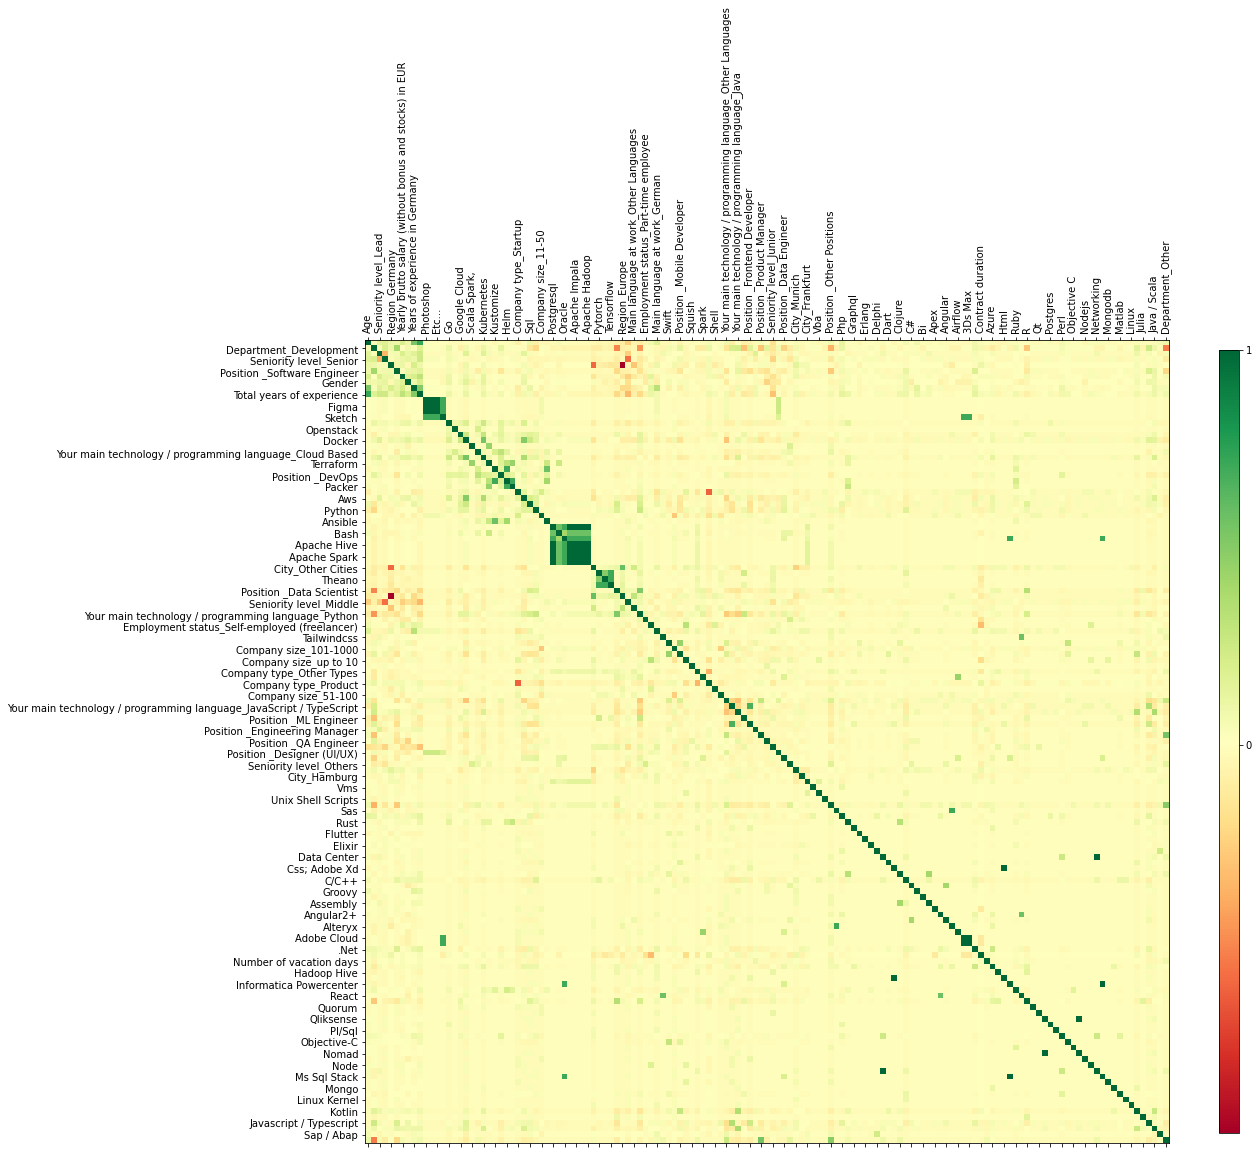

In [51]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(0,len(corr.columns),2), corr.columns[::2], rotation=90);
    plt.yticks(range(1,len(corr.columns),2), corr.columns[1::2]);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

X_val = ohedf.corr().values
d = sch.distance.pdist(X_val) 
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.7*d.max(), 'distance')
columns = [ohedf.columns.tolist()[i] for i in list((np.argsort(ind)))]
ordered_df = ohedf.reindex(columns, axis=1)

plot_corr(ordered_df, size=18)

  0%|          | 0/10 [00:00<?, ?it/s]


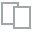
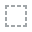
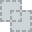
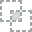
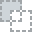
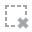
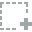
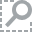
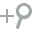
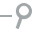
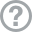
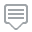
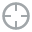
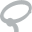
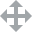
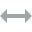
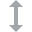
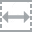
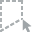
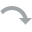
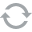
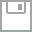
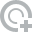
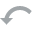
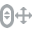
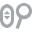
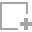
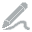
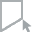
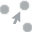
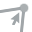
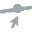

In [52]:
plot(ohedf, 'Age', 'Yearly brutto salary (without bonus and stocks) in EUR')

  0%|          | 0/10 [00:00<?, ?it/s]


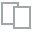
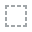
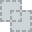
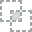
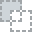
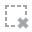
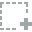
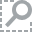
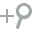
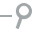
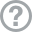
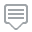
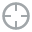
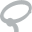
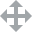
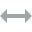
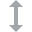
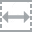
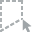
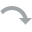
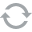
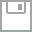
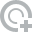
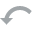
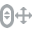
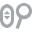
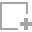
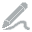
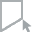
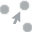
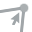
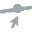

In [53]:
plot(ohedf, 'Total years of experience', 'Yearly brutto salary (without bonus and stocks) in EUR')

  0%|          | 0/10 [00:00<?, ?it/s]


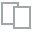
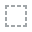
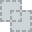
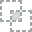
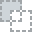
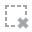
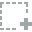
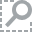
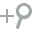
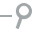
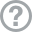
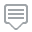
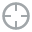
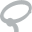
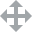
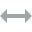
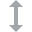
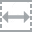
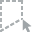
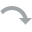
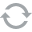
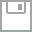
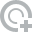
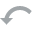
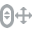
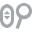
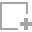
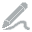
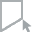
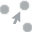
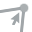
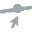

In [54]:
plot(ohedf, 'Years of experience in Germany', 'Yearly brutto salary (without bonus and stocks) in EUR')

In [55]:
def scatter_plot(train, pred):
    mse = mean_squared_error(train, pred, squared=True)
    mae = mean_absolute_error(train, pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    ax.scatter(train, pred, c='#ff7f0e', edgecolors=(0, 0, 0))
    ax.plot([train.min(), train.max()], [train.min(), train.max()], 'b--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.grid(True, linestyle=(0, (1, 5)))
    plt.title('Predicted vs Actual Salary')
    plt.show()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

In [57]:
lreg = LinearRegression()
cross_val_score(lreg, X_train, y_train, cv=10)

array([0.41112035, 0.02571044, 0.02111162, 0.3057932 , 0.19544261,
       0.27126961, 0.26526522, 0.18763197, 0.41931011, 0.28788116])

Mean Squared Error: 1117185034.814846
Mean Absolute Error: 14454.339830741552


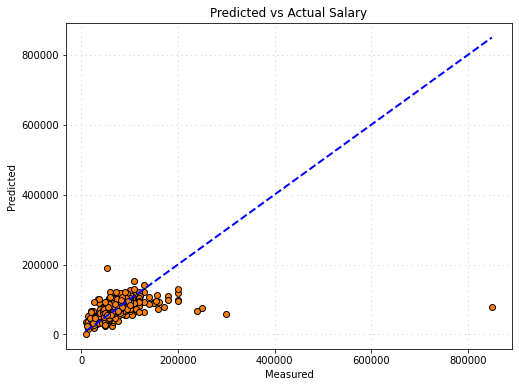

In [58]:
lreg = LinearRegression()
ypred = cross_val_predict(lreg, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [59]:
tt = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
cross_val_score(tt, X_train, y_train, cv=10)

array([0.36351232, 0.03183022, 0.03319766, 0.31248182, 0.18374594,
       0.48979798, 0.44643477, 0.17097767, 0.44547969, 0.36114304])

Mean Squared Error: 1092437990.4106786
Mean Absolute Error: 13311.786962382272


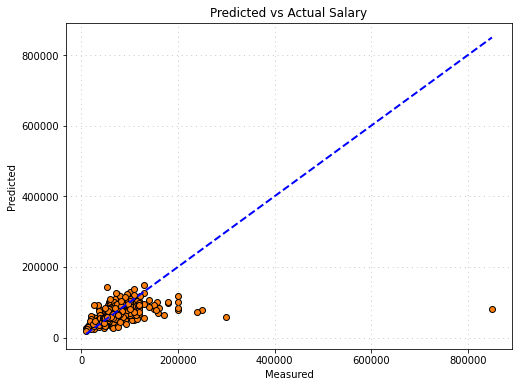

In [60]:
tt = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
ypred = cross_val_predict(tt, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [61]:
tt = TransformedTargetRegressor(regressor=Ridge(alpha=10), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('ridge', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.35562854, 0.02767536, 0.04119815, 0.32601916, 0.18240647,
       0.51985483, 0.45872346, 0.19890668, 0.4403775 , 0.36035609])

Mean Squared Error: 1084967229.278909
Mean Absolute Error: 13168.290659228764


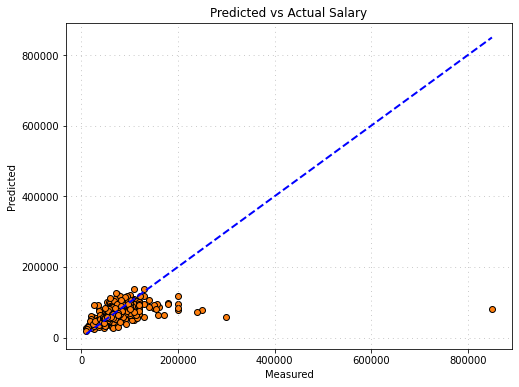

In [62]:
tt = TransformedTargetRegressor(regressor=Ridge(alpha=10), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('ridge', tt)])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [63]:
pipe = Pipeline([('scaler', StandardScaler()), ('polyfeatures', PolynomialFeatures()), ('ridge', Ridge(alpha=10000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.42211669, 0.10970614, 0.02210762, 0.33512217, 0.15381787,
       0.30807944, 0.41200238, 0.31970781, 0.28321569, 0.27266527])

In [64]:
tt = TransformedTargetRegressor(regressor=Ridge(alpha=1000), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('polyfeatures', PolynomialFeatures()), ('ridge', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.47702905, 0.16750789, 0.03400456, 0.2697754 , 0.19556684,
       0.42567051, 0.56746901, 0.32798768, 0.4015857 , 0.24730607])

Mean Squared Error: 1067430414.6020771
Mean Absolute Error: 12868.795272799824


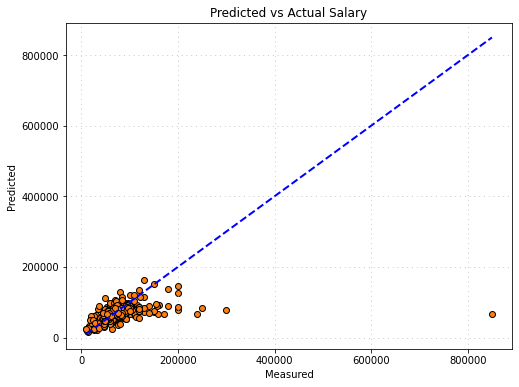

In [65]:
tt = TransformedTargetRegressor(regressor=Ridge(alpha=1000), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('polyfeatures', PolynomialFeatures()), ('ridge', tt)])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [66]:
hreg = HuberRegressor(max_iter=3000, alpha=0.001)
cross_val_score(hreg, X_train, y_train, cv=10)

array([0.2862842 , 0.0846927 , 0.03135281, 0.36254861, 0.21721208,
       0.5104135 , 0.40635592, 0.4392147 , 0.44487435, 0.53649228])

Mean Squared Error: 1073911612.5789301
Mean Absolute Error: 12442.531094314205


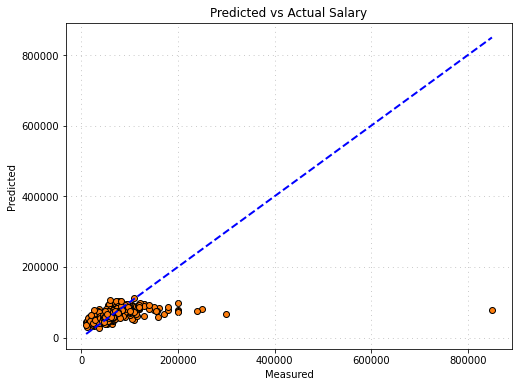

In [67]:
hreg = HuberRegressor(max_iter=3000, alpha=0.001)
ypred = cross_val_predict(hreg, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [68]:
hreg = HuberRegressor(max_iter=3000, alpha=1)
cross_val_score(hreg, X_train, y_train, cv=10)

array([ 0.19456014, -0.04690796,  0.01594925,  0.08925826,  0.0676672 ,
        0.20304768,  0.0833829 ,  0.18429007,  0.12348074,  0.25019556])

In [69]:
hreg = HuberRegressor(max_iter=3000, alpha=0.001)
pipe = Pipeline([('scaler', StandardScaler()), ('huber', hreg)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.42006567, 0.08549728, 0.03690338, 0.35971895, 0.20396833,
       0.54813245, 0.45504374, 0.44733615, 0.47602286, 0.55324343])

Mean Squared Error: 1054600767.0430421
Mean Absolute Error: 12327.573967028902


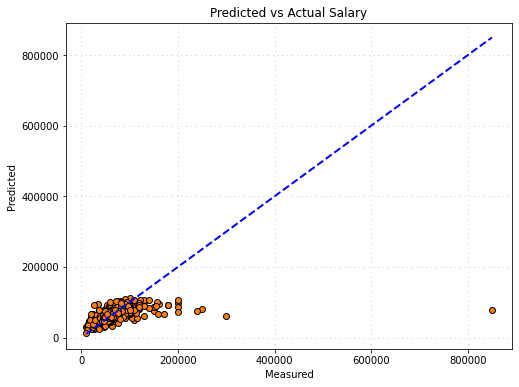

In [70]:
hreg = HuberRegressor(max_iter=3000, alpha=0.001)
pipe = Pipeline([('scaler', StandardScaler()), ('huber', hreg)])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [71]:
hreg = HuberRegressor(max_iter=3000, alpha=1)
pipe = Pipeline([('scaler', StandardScaler()), ('huber', hreg)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([ 0.0562866 ,  0.01436448, -0.01108234,  0.0100266 ,  0.02256068,
        0.09287149,  0.08148481,  0.09833109,  0.06002385,  0.10205572])

In [72]:
tt = TransformedTargetRegressor(regressor=HuberRegressor(max_iter=3000, alpha=0.001), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('huber', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.39231038, 0.06882459, 0.03167771, 0.33410512, 0.1748854 ,
       0.54599074, 0.44448607, 0.30793177, 0.47922273, 0.46905392])

In [73]:
tt = TransformedTargetRegressor(regressor=HuberRegressor(max_iter=3000, alpha=1), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('huber', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.3920519 , 0.06890617, 0.03195704, 0.33414269, 0.17491805,
       0.54630492, 0.43348323, 0.30816667, 0.4790971 , 0.46882525])

In [74]:
greg = GammaRegressor(alpha=0.01, max_iter=3000)
cross_val_score(greg, X_train, y_train, cv=10)

array([0.37487212, 0.0693723 , 0.20099268, 0.34658963, 0.36213123,
       0.49854839, 0.38102051, 0.34841303, 0.49533094, 0.43315398])

Mean Squared Error: 1086117782.0413008
Mean Absolute Error: 13541.15789649612


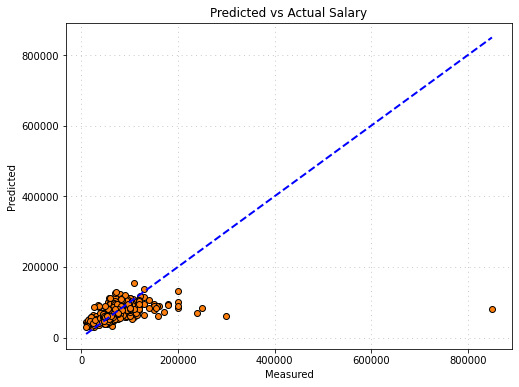

In [75]:
greg = GammaRegressor(alpha=0.01, max_iter=3000)
ypred = cross_val_predict(greg, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [76]:
greg = GammaRegressor(alpha=1, max_iter=3000)
cross_val_score(greg, X_train, y_train, cv=10)

array([ 0.27766538, -0.10081524,  0.15787109,  0.20276778,  0.22023198,
        0.31372492,  0.14536842,  0.2741984 ,  0.25366464,  0.29777829])

In [77]:
pipe = Pipeline([('scaler', StandardScaler()), ('gamma', GammaRegressor(alpha=0.01, max_iter=3000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.4575623 , 0.01936429, 0.20459416, 0.3003356 , 0.30623822,
       0.46718234, 0.43300377, 0.22555184, 0.50563044, 0.36217492])

In [78]:
pipe = Pipeline([('scaler', StandardScaler()), ('gamma', GammaRegressor(alpha=1, max_iter=3000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.35340744, 0.08405159, 0.135225  , 0.34776138, 0.26731354,
       0.45111932, 0.36720575, 0.37593682, 0.43451115, 0.41924281])

In [79]:
tt = TransformedTargetRegressor(regressor=GammaRegressor(alpha=0.01, max_iter=3000), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('gamma', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.34512619, 0.02359058, 0.04360029, 0.31227539, 0.17852738,
       0.50037513, 0.44602965, 0.16465136, 0.44462898, 0.33689042])

In [80]:
treg = TweedieRegressor(power=2.1, alpha=0.001, max_iter=3000)
cross_val_score(treg, X_train, y_train, cv=10)

array([0.42324057, 0.0500876 , 0.2209258 , 0.34206008, 0.34822774,
       0.49682041, 0.40890539, 0.2891985 , 0.51020048, 0.42221576])

In [81]:
treg = TweedieRegressor(power=2.1, alpha=1, max_iter=3000)
cross_val_score(treg, X_train, y_train, cv=10)

array([ 0.25637162, -0.13922021,  0.15763444,  0.18285051,  0.18898703,
        0.27757986,  0.09932893,  0.22552119,  0.20909898,  0.25341558])

In [82]:
pipe = Pipeline([('scaler', StandardScaler()), ('tweedie', TweedieRegressor(power=2.1, alpha=0.001, max_iter=3000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.46416269, 0.02213228, 0.21074901, 0.2881579 , 0.30062163,
       0.45926546, 0.43747884, 0.21464712, 0.50778072, 0.36071005])

Mean Squared Error: 1107963726.190962
Mean Absolute Error: 14137.259923480284


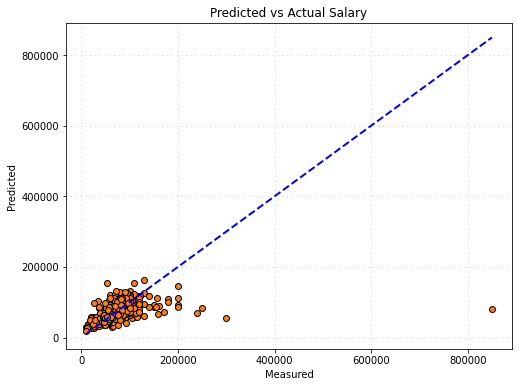

In [83]:
pipe = Pipeline([('scaler', StandardScaler()), ('tweedie', TweedieRegressor(power=2.1, alpha=0.001, max_iter=3000))])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [84]:
pipe = Pipeline([('scaler', StandardScaler()), ('tweedie', TweedieRegressor(power=2.1, alpha=1, max_iter=3000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.24380116, 0.0939211 , 0.07558474, 0.28495861, 0.18245767,
       0.32964604, 0.24877572, 0.29533204, 0.31503015, 0.33302721])

In [85]:
tt = TransformedTargetRegressor(regressor=TweedieRegressor(power=2.1, alpha=0.01, max_iter=3000), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('tweedie', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.34249382, 0.02260463, 0.04320119, 0.31164647, 0.17799656,
       0.5041526 , 0.44745187, 0.17000634, 0.44315589, 0.33465959])

In [86]:
kreg = KernelRidge(alpha=0.001)
cross_val_score(kreg, X_train, y_train, cv=10)

array([ 0.33707974, -0.0188676 ,  0.05158601,  0.28431225,  0.04374758,
        0.25456055,  0.17924114,  0.20013753,  0.42572158,  0.20258895])

In [87]:
kreg = KernelRidge()
cross_val_score(kreg, X_train, y_train, cv=10)

array([ 0.33304858, -0.00812305,  0.05051102,  0.31138266,  0.07989578,
        0.29962144,  0.18388458,  0.23408777,  0.42406673,  0.24873627])

In [88]:
pipe = Pipeline([('scaler', StandardScaler()), ('krreg', KernelRidge(alpha=0.001))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([ -5.65486734,  -5.94973316,  -0.85278829, -17.46485858,
        -4.1775452 , -10.05382099,  -9.28232887, -11.95501172,
        -9.81527794, -13.80192449])

In [89]:
pipe = Pipeline([('scaler', StandardScaler()), ('krreg', KernelRidge())])
cross_val_score(pipe, X_train, y_train, cv=10)

array([ -5.65448868,  -5.94876606,  -0.85113495, -17.45529443,
        -4.17436782, -10.06250104,  -9.27636678, -11.95163496,
        -9.81083768, -13.79110978])

In [90]:
kreg = KernelRidge(alpha=0.001, kernel='polynomial')
cross_val_score(kreg, X_train, y_train, cv=10)

array([-1.87105837e+01, -2.00178201e+04, -1.04984476e+03, -6.40159709e+00,
       -9.37984286e-01, -3.10187309e+03, -9.13179907e+02, -1.05335643e+01,
       -2.21642928e+01, -6.37129578e+03])

In [91]:
kreg = KernelRidge(alpha=1, kernel='polynomial')
cross_val_score(kreg, X_train, y_train, cv=10)

array([-2.97233110e+00, -8.20260052e+01, -3.69827900e+01, -8.45916449e-01,
        3.40891970e-01, -1.01676377e+02, -4.58619600e+02, -7.33042650e-01,
       -2.57693488e+00, -8.80587316e+01])

In [92]:
kreg = KernelRidge(alpha=1, kernel='polynomial', degree=2)
cross_val_score(kreg, X_train, y_train, cv=10)

array([ 0.05716886, -0.91615294, -0.10326559,  0.35462485,  0.25186051,
        0.36313482, -0.08984105,  0.22047268,  0.487087  , -1.63507195])

In [93]:
kreg = KernelRidge(alpha=10, kernel='polynomial', degree=2)
cross_val_score(kreg, X_train, y_train, cv=10)

array([ 0.12763865, -0.06644519,  0.0144321 ,  0.32631092,  0.20943854,
        0.41170613,  0.16459214,  0.35651576,  0.47660508,  0.29839568])

In [94]:
pipe = Pipeline([('scaler', StandardScaler()), ('krreg', KernelRidge(alpha=10, kernel='polynomial', degree=2))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.39648888, 0.05230942, 0.02942881, 0.39272779, 0.17550812,
       0.45698277, 0.40509911, 0.42380126, 0.39697575, 0.44636208])

In [95]:
tt = TransformedTargetRegressor(regressor=KernelRidge(alpha=1, kernel='polynomial', degree=2), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('krreg', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.44724639, 0.05506716, 0.04118524, 0.38895665, 0.20958298,
       0.57846827, 0.55384951, 0.40803222, 0.44121429, 0.44964055])

Mean Squared Error: 1051526042.2019823
Mean Absolute Error: 12272.172241234417


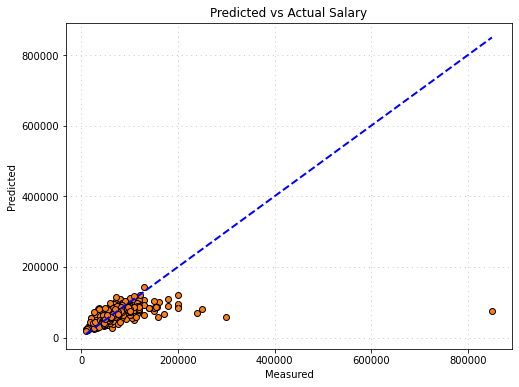

In [96]:
tt = TransformedTargetRegressor(regressor=KernelRidge(alpha=1, kernel='polynomial', degree=2), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('scaler', StandardScaler()), ('krreg', tt)])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [97]:
kreg = KernelRidge(alpha=0.001, kernel='rbf')
cross_val_score(kreg, X_train, y_train, cv=10)

array([-0.75792201, -0.30318208,  0.06460724, -0.19383886,  0.30652173,
       -2.35111223,  0.08547574, -0.91721139,  0.13190597, -0.90274138])

In [98]:
kreg = KernelRidge(alpha=1, kernel='rbf')
cross_val_score(kreg, X_train, y_train, cv=10)

array([-0.32330298, -0.06546093,  0.02455058,  0.30965615,  0.2211727 ,
       -0.05246607,  0.23153895,  0.28170001,  0.17653619, -0.01082694])

In [99]:
tt = TransformedTargetRegressor(regressor=KernelRidge(alpha=0.001, kernel='rbf'), func=np.log, inverse_func=np.exp)
cross_val_score(tt, X_train, y_train, cv=10)

array([-0.6636531 , -0.30657262,  0.00602116, -0.0839871 , -0.09460492,
       -0.48697285,  0.23055553, -0.81941574,  0.13450298, -0.97046037])

In [100]:
pipe = Pipeline([('scaler', StandardScaler()), ('krreg', KernelRidge(alpha=1, kernel='rbf'))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([ 0.37197515, -0.14505222,  0.00626031, -0.31065588,  0.12547882,
       -0.11505033,  0.28947437,  0.0305314 ,  0.42716759, -0.27507552])

In [101]:
df.query('`Yearly brutto salary (without bonus and stocks) in EUR` > 200000')

Age  Gender          City           Position   \
576  24.0     1.0        Munich      Data Scientist   
630  40.0     1.0  Other Cities   Software Engineer   
778  42.0     1.0        Berlin  Frontend Developer   
804  20.0     1.0        Berlin    Mobile Developer   

     Total years of experience  Years of experience in Germany  \
576                        1.0                             1.0   
630                       20.0                             0.0   
778                       18.0                             5.0   
804                        5.0                             2.0   

    Seniority level Your main technology / programming language  \
576          Junior                                           C   
630            Lead                             Other Languages   
778          Senior                     JavaScript / TypeScript   
804            Lead                                           C   

     Yearly brutto salary (without bonus and stocks) in EUR  \
576                                           300000.0        
630                                           250000.0        
778                                           850000.0        
804                                           240000.0        

     Number of vacation days  ...  Sql  Squish Swift Tailwindcss Tensorflow  \
576                     27.6  ...  1.0     0.0   1.0         0.0        0.0   
630                     45.0  ...  0.0     0.0   0.0         0.0        0.0   
778                     35.0  ...  0.0     0.0   0.0         0.0        0.0   
804                     27.0  ...  0.0     0.0   0.0         0.0        0.0   

    Terraform Theano  Unix Shell Scripts  Vba  Vms  
576       0.0    0.0                 0.0  0.0  0.0  
630       0.0    0.0                 0.0  0.0  0.0  
778       0.0    0.0                 0.0  0.0  0.0  
804       0.0    0.0                 0.0  0.0  0.0  

[4 rows x 108 columns]

In [102]:
X = df.drop('Yearly brutto salary (without bonus and stocks) in EUR', axis=1).drop(df.index[df['Yearly brutto salary (without bonus and stocks) in EUR'] > 200000])
y = df['Yearly brutto salary (without bonus and stocks) in EUR'].drop(df.index[df['Yearly brutto salary (without bonus and stocks) in EUR'] > 200000])
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (1244, 107)
y shape: (1244,)


In [103]:
cat_feats = ['Gender', 'City', 'Position ', 'Seniority level', 'Your main technology / programming language', 'Employment status', 'Сontract duration', 'Main language at work', 'Company size', 'Company type', 'Region', 'Department', '.Net', '3Ds Max', 'Adobe Cloud', 'Airflow', 'Alteryx', 'Angular', 'Angular2+', 'Ansible', 'Apache Hadoop', 'Apache Hive', 'Apache Impala', 'Apache Spark', 'Apex', 'Assembly', 'Aws', 'Azure', 'Bash', 'Bi', 'C#', 'C/C++', 'Clojure', 'Css; Adobe Xd', 'Dart', 'Data Center', 'Delphi', 'Docker', 'Elixir', 'Erlang', 'Etc...', 'Figma', 'Flutter', 'Go', 'Google Cloud', 'Graphql', 'Groovy', 'Hadoop Hive', 'Helm', 'Html', 'Informatica Powercenter', 'Java / Scala', 'Javascript / Typescript', 'Julia', 'Kotlin', 'Kubernetes', 'Kustomize', 'Linux', 'Linux Kernel', 'Matlab', 'Mongo', 'Mongodb', 'Ms Sql Stack', 'Networking', 'Node', 'Nodejs', 'Nomad', 'Objective C', 'Objective-C', 'Openstack', 'Oracle', 'Packer', 'Perl', 'Photoshop', 'Php', 'Pl/Sql', 'Postgres', 'Postgresql', 'Python', 'Pytorch', 'Qliksense', 'Qt', 'Quorum', 'R', 'React', 'Ruby', 'Rust', 'Sap / Abap', 'Sas', 'Scala Spark,', 'Shell', 'Sketch', 'Spark', 'Sql', 'Squish', 'Swift', 'Tailwindcss', 'Tensorflow', 'Terraform', 'Theano', 'Unix Shell Scripts', 'Vba', 'Vms']
num_feats = ['Age', 'Total years of experience', 'Years of experience in Germany', 'Number of vacation days']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

In [158]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()]}
preprocessors = ColumnTransformer([('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('linear', LinearRegression())])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [159]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']]

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
0          PolynomialEncoder()                      -4.084449e+14   
1              TargetEncoder()                      -1.149479e+04   
2            CatBoostEncoder()                      -1.180966e+04   
3          JamesSteinEncoder()                      -1.151344e+04   
4                GLMMEncoder()                                NaN   
5  BackwardDifferenceEncoder()                      -1.134006e+15   

   std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
0                      5.915755e+14                                  4   
1                      1.282165e+03                                  1   
2                      1.293175e+03                                  3   
3                      1.264073e+03                                  2   
4                               NaN                                  6   
5                      1.942914e+15                                  5   

   mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
0                     -4.296458e+31                     1.144606e+32   
1                     -3.018138e+08                     6.829685e+07   
2                     -3.214788e+08                     7.663346e+07   
3                     -3.035557e+08                     6.860672e+07   
4                               NaN                              NaN   
5                     -2.539828e+32                     6.484481e+32   

   rank_test_neg_mean_squared_error  mean_test_r2   std_test_r2  rank_test_r2  
0                                 4 -9.291050e+22  2.425264e+23             4  
1                                 1  3.701175e-01  1.128944e-01             1  
2                                 3  3.317979e-01  1.136731e-01             3  
3                                 2  3.668204e-01  1.084301e-01             2  
4                                 6           NaN           NaN             6  
5                                 5 -5.929305e+23  1.508725e+24             5

In [161]:
preprocessors = ColumnTransformer([('target_encode', ce.target_encoder.TargetEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('linear', LinearRegression())])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.35219148, 0.39243527, 0.43760201, 0.34015208, 0.34948973,
       0.45530757, 0.52530129, 0.07403626, 0.41139789, 0.36326098])

Mean Squared Error: 301678340.71792895
Mean Absolute Error: 11491.433868141603


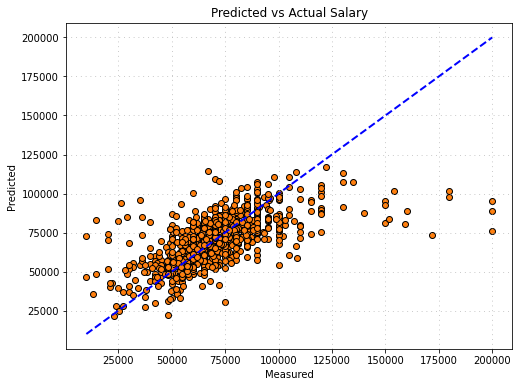

In [162]:
preprocessors = ColumnTransformer([('target_encode', ce.target_encoder.TargetEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('linear', LinearRegression())])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [163]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()]}
preprocessors = ColumnTransformer([('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
tt = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('preprocess', preprocessors), ('linear', tt)])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [164]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']]

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
0          PolynomialEncoder()                                NaN   
1              TargetEncoder()                      -11475.773523   
2            CatBoostEncoder()                      -11840.713730   
3          JamesSteinEncoder()                      -11496.988897   
4                GLMMEncoder()                                NaN   
5  BackwardDifferenceEncoder()                                NaN   

   std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
0                               NaN                                  4   
1                       1386.432136                                  1   
2                       1483.897405                                  3   
3                       1431.797061                                  2   
4                               NaN                                  5   
5                               NaN                                  6   

   mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
0                               NaN                              NaN   
1                     -3.126272e+08                     7.506321e+07   
2                     -3.409426e+08                     8.970099e+07   
3                     -3.182320e+08                     8.340347e+07   
4                               NaN                              NaN   
5                               NaN                              NaN   

   rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
0                                 4           NaN          NaN             4  
1                                 1      0.351364     0.105017             1  
2                                 3      0.294690     0.124862             3  
3                                 2      0.341237     0.116246             2  
4                                 5           NaN          NaN             5  
5                                 6           NaN          NaN             6

In [165]:
preprocessors = ColumnTransformer([('catboost_encode', ce.target_encoder.TargetEncoder(), cat_feats)])
tt = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
pipe = Pipeline([('preprocess', preprocessors), ('linear', tt)])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.33060281, 0.43819143, 0.39408849, 0.27145274, 0.34619432,
       0.40084848, 0.5377614 , 0.11404618, 0.35283437, 0.32761844])

In [170]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()],
             'ridge__alpha': np.logspace(-3, 3, 7)}
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('ridge', Ridge())])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [171]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']]

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
0           PolynomialEncoder()                      -11563.250083   
1           PolynomialEncoder()                      -11558.688636   
2           PolynomialEncoder()                      -11521.862538   
3           PolynomialEncoder()                      -11359.355228   
4           PolynomialEncoder()                      -11121.770812   
5           PolynomialEncoder()                      -11177.435062   
6           PolynomialEncoder()                      -12786.616310   
7               TargetEncoder()                      -11312.326099   
8               TargetEncoder()                      -11309.350121   
9               TargetEncoder()                      -11293.088821   
10              TargetEncoder()                      -11262.248059   
11              TargetEncoder()                      -11169.568332   
12              TargetEncoder()                      -10999.820518   
13              TargetEncoder()                      -11134.196371   
14            CatBoostEncoder()                      -11684.919013   
15            CatBoostEncoder()                      -11681.407701   
16            CatBoostEncoder()                      -11658.924175   
17            CatBoostEncoder()                      -11610.492326   
18            CatBoostEncoder()                      -11495.679688   
19            CatBoostEncoder()                      -11201.915122   
20            CatBoostEncoder()                      -11245.607733   
21          JamesSteinEncoder()                      -11314.553961   
22          JamesSteinEncoder()                      -11311.396755   
23          JamesSteinEncoder()                      -11295.348057   
24          JamesSteinEncoder()                      -11263.164337   
25          JamesSteinEncoder()                      -11168.738648   
26          JamesSteinEncoder()                      -10994.598856   
27          JamesSteinEncoder()                      -11140.536987   
28                GLMMEncoder()                                NaN   
29                GLMMEncoder()                                NaN   
30                GLMMEncoder()                                NaN   
31                GLMMEncoder()                                NaN   
32                GLMMEncoder()                                NaN   
33                GLMMEncoder()                                NaN   
34                GLMMEncoder()                                NaN   
35  BackwardDifferenceEncoder()                      -11563.089770   
36  BackwardDifferenceEncoder()                      -11557.100073   
37  BackwardDifferenceEncoder()                      -11508.415827   
38  BackwardDifferenceEncoder()                      -11313.956730   
39  BackwardDifferenceEncoder()                      -11155.307427   
40  BackwardDifferenceEncoder()                      -11245.276817   
41  BackwardDifferenceEncoder()                      -12817.106719   

    std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
0                        1123.036357                                 29   
1                        1122.585130                                 27   
2                        1120.128377                                 25   
3                        1109.728272                                 22   
4                        1082.264674                                  3   
5                        1106.175597                                  9   
6                        1049.490706                                 34   
7                        1243.347063                                 19   
8                        1239.763200                                 17   
9                        1227.027525                                 15   
10                       1210.785368                                 13   
11                       1194.546574                                  8   
12               

In [173]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('target_encode', ce.target_encoder.TargetEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('ridge', Ridge(alpha=100))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.43236968, 0.36530632, 0.47000244, 0.41309025, 0.35933086,
       0.4515894 , 0.57610991, 0.21213413, 0.41397261, 0.41471018])

Mean Squared Error: 284015726.8768174
Mean Absolute Error: 10997.617258058204


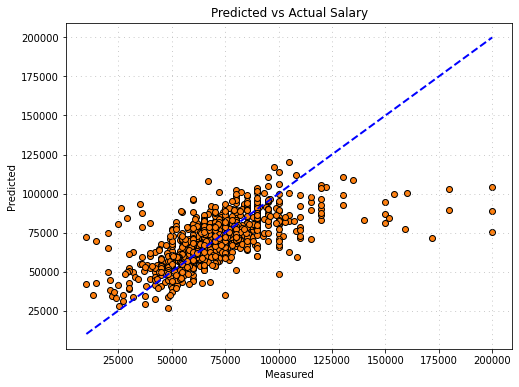

In [174]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('target_encode', ce.target_encoder.TargetEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('ridge', Ridge(alpha=100))])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [175]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()],
             'huber__alpha': np.logspace(-3, 3, 7)}
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('huber', HuberRegressor(max_iter=3000))])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [176]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']]

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
0           PolynomialEncoder()                      -10589.753063   
1               TargetEncoder()                      -11420.503609   
2             CatBoostEncoder()                      -11530.393742   
3           JamesSteinEncoder()                      -11445.516360   
4                 GLMMEncoder()                                NaN   
5   BackwardDifferenceEncoder()                      -10642.488447   
6           PolynomialEncoder()                      -11153.889221   
7               TargetEncoder()                      -11422.161450   
8             CatBoostEncoder()                      -11514.864070   
9           JamesSteinEncoder()                      -11444.638103   
10                GLMMEncoder()                                NaN   
11  BackwardDifferenceEncoder()                      -11281.780229   
12          PolynomialEncoder()                      -13222.969897   
13              TargetEncoder()                      -11419.362675   
14            CatBoostEncoder()                      -11527.247343   
15          JamesSteinEncoder()                      -11427.308114   
16                GLMMEncoder()                                NaN   
17  BackwardDifferenceEncoder()                      -13215.568897   
18          PolynomialEncoder()                      -14836.935365   
19              TargetEncoder()                      -11416.386234   
20            CatBoostEncoder()                      -11530.219478   
21          JamesSteinEncoder()                      -11439.585790   
22                GLMMEncoder()                                NaN   
23  BackwardDifferenceEncoder()                      -14823.211128   
24          PolynomialEncoder()                      -15149.129649   
25              TargetEncoder()                      -11415.733473   
26            CatBoostEncoder()                      -11524.925158   
27          JamesSteinEncoder()                      -11447.940004   
28                GLMMEncoder()                                NaN   
29  BackwardDifferenceEncoder()                      -15147.490086   
30          PolynomialEncoder()                      -15183.177970   
31              TargetEncoder()                      -11419.564231   
32            CatBoostEncoder()                      -11525.536691   
33          JamesSteinEncoder()                      -11439.334119   
34                GLMMEncoder()                                NaN   
35  BackwardDifferenceEncoder()                      -15183.011494   
36          PolynomialEncoder()                      -15186.605078   
37              TargetEncoder()                      -11425.529704   
38            CatBoostEncoder()                      -11518.144802   
39          JamesSteinEncoder()                      -11448.304760   
40                GLMMEncoder()                                NaN   
41  BackwardDifferenceEncoder()                      -15186.600403   

    std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
0                        1221.893666                                  1   
1                        1141.827887                                  9   
2                        1065.904133                                 25   
3                        1133.382552                                 16   
4                                NaN                                 39   
5                        1198.526216                                  2   
6                        1158.539190                                  3   
7                        1141.478981                                 10   
8                        1086.931127                                 19   
9                        1136.400994                                 15   
10                               NaN                                 38   
11                       1172.087576                                  4   
12               

In [177]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('huber', HuberRegressor(max_iter=3000, alpha=0.001))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.42171022, 0.37334737, 0.40342704, 0.32642802, 0.39301398,
       0.41154711, 0.63597967, 0.3377785 , 0.35017074, 0.40050872])

Mean Squared Error: 289255955.6876518
Mean Absolute Error: 10588.362447796582


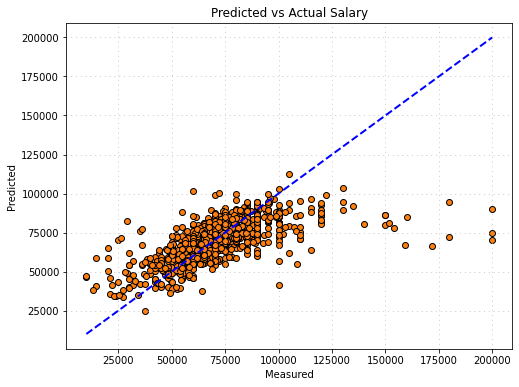

In [178]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('huber', HuberRegressor(max_iter=3000, alpha=0.001))])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [180]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()],
             'gamma__alpha': np.logspace(-3, 3, 7)}
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('gamma', GammaRegressor(max_iter=3000))])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [181]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']]

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
0           PolynomialEncoder()                      -11255.251448   
1               TargetEncoder()                      -15242.918507   
2             CatBoostEncoder()                      -15242.918507   
3           JamesSteinEncoder()                      -15242.918507   
4                 GLMMEncoder()                                NaN   
5   BackwardDifferenceEncoder()                      -11222.534762   
6           PolynomialEncoder()                      -11020.478100   
7               TargetEncoder()                      -15242.918507   
8             CatBoostEncoder()                      -15242.918507   
9           JamesSteinEncoder()                      -15242.918507   
10                GLMMEncoder()                                NaN   
11  BackwardDifferenceEncoder()                      -11084.719719   
12          PolynomialEncoder()                      -11163.133920   
13              TargetEncoder()                      -15242.918507   
14            CatBoostEncoder()                      -15242.918507   
15          JamesSteinEncoder()                      -15242.918507   
16                GLMMEncoder()                                NaN   
17  BackwardDifferenceEncoder()                      -11267.875163   
18          PolynomialEncoder()                      -12579.044537   
19              TargetEncoder()                      -15242.918507   
20            CatBoostEncoder()                      -15242.918507   
21          JamesSteinEncoder()                      -15242.918507   
22                GLMMEncoder()                                NaN   
23  BackwardDifferenceEncoder()                      -12632.066630   
24          PolynomialEncoder()                      -14555.902228   
25              TargetEncoder()                      -15242.918507   
26            CatBoostEncoder()                      -15242.918507   
27          JamesSteinEncoder()                      -15242.918507   
28                GLMMEncoder()                                NaN   
29  BackwardDifferenceEncoder()                      -14545.162711   
30          PolynomialEncoder()                      -15158.542283   
31              TargetEncoder()                      -15242.918507   
32            CatBoostEncoder()                      -15242.918507   
33          JamesSteinEncoder()                      -15242.918507   
34                GLMMEncoder()                                NaN   
35  BackwardDifferenceEncoder()                      -15156.538183   
36          PolynomialEncoder()                      -15234.319490   
37              TargetEncoder()                      -15242.918507   
38            CatBoostEncoder()                      -15242.918507   
39          JamesSteinEncoder()                      -15242.918507   
40                GLMMEncoder()                                NaN   
41  BackwardDifferenceEncoder()                      -15234.102948   

    std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
0                        1067.686851                                  5   
1                        1258.451627                                 15   
2                        1258.451627                                 15   
3                        1258.451627                                 15   
4                                NaN                                 36   
5                        1048.663578                                  4   
6                        1037.651327                                  1   
7                        1258.451627                                 15   
8                        1258.451627                                 15   
9                        1258.451627                                 15   
10                               NaN                                 37   
11                       1036.087166                                  2   
12               

In [182]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('gamma', GammaRegressor(alpha=0.01, max_iter=3000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.35321112, 0.31881472, 0.47485431, 0.45193065, 0.53063503,
       0.50762819, 0.5574299 , 0.3183407 , 0.47871568, 0.35059086])

Mean Squared Error: 286395872.9228995
Mean Absolute Error: 11020.186952709175


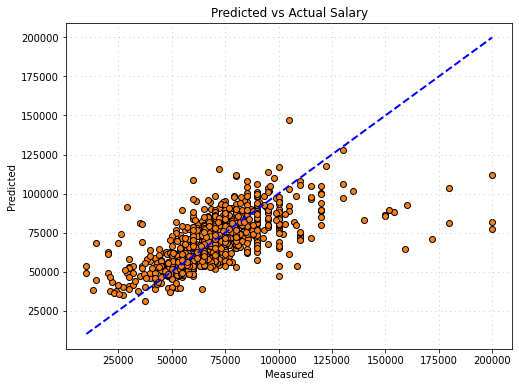

In [183]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('gamma', GammaRegressor(alpha=0.01, max_iter=3000))])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [184]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()],
             'tweedie__alpha': np.logspace(-3, 3, 7), 'tweedie__power': [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]}
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('tweedie', TweedieRegressor(max_iter=3000))])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [185]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].nsmallest(10, 'rank_test_neg_mean_absolute_error')

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
24           PolynomialEncoder()                      -11011.491999   
31           PolynomialEncoder()                      -11013.076728   
23           PolynomialEncoder()                      -11013.214022   
32           PolynomialEncoder()                      -11016.577803   
16           PolynomialEncoder()                      -11016.831420   
15           PolynomialEncoder()                      -11020.478100   
40           PolynomialEncoder()                      -11028.026180   
7            PolynomialEncoder()                      -11041.765376   
381  BackwardDifferenceEncoder()                      -11079.284229   
373  BackwardDifferenceEncoder()                      -11080.060415   

     std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
24                        1099.282908                                  1   
31                        1039.981071                                  2   
23                        1039.615000                                  3   
32                        1099.136700                                  4   
16                        1099.230068                                  5   
15                        1037.651327                                  6   
40                        1100.863435                                  7   
7                         1060.002740                                  8   
381                       1039.701864                                  9   
373                       1035.740396                                 10   

     mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
24                      -2.921279e+08                     7.031423e+07   
31                      -2.847208e+08                     6.482613e+07   
23                      -2.854208e+08                     6.509188e+07   
32                      -2.917586e+08                     7.021139e+07   
16                      -2.928735e+08                     7.030322e+07   
15                      -2.864501e+08                     6.537362e+07   
40                      -2.916485e+08                     7.011969e+07   
7                       -2.872915e+08                     6.554953e+07   
381                     -2.906288e+08                     6.491326e+07   
373                     -2.911997e+08                     6.505850e+07   

     rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
24                                 31      0.394457     0.099106            26  
31                                  3      0.408372     0.090814             2  
23                                  4      0.406841     0.092512             4  
32                                 28      0.395383     0.097269            23  
16                                 33      0.392606     0.101249            31  
15                                  7      0.404540     0.094678             6  
40                                 27      0.395721     0.095695            22  
7                                  10      0.402425     0.097548             9  
381                                22      0.396348     0.087311            20  
373                                24      0.394978     0.089440            25

In [186]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].nsmallest(10, 'rank_test_neg_mean_squared_error')

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
30           PolynomialEncoder()                      -11090.407897   
22           PolynomialEncoder()                      -11097.083850   
31           PolynomialEncoder()                      -11013.076728   
23           PolynomialEncoder()                      -11013.214022   
14           PolynomialEncoder()                      -11112.059200   
6            PolynomialEncoder()                      -11125.077188   
15           PolynomialEncoder()                      -11020.478100   
21           PolynomialEncoder()                      -11225.572073   
380  BackwardDifferenceEncoder()                      -11113.541551   
7            PolynomialEncoder()                      -11041.765376   

     std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
30                        1042.064892                                 15   
22                        1050.222861                                 16   
31                        1039.981071                                  2   
23                        1039.615000                                  3   
14                        1059.559965                                 18   
6                         1058.143729                                 22   
15                        1037.651327                                  6   
21                        1062.807735                                 34   
380                       1022.449030                                 20   
7                         1060.002740                                  8   

     mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
30                      -2.838422e+08                     6.354249e+07   
22                      -2.845255e+08                     6.410701e+07   
31                      -2.847208e+08                     6.482613e+07   
23                      -2.854208e+08                     6.509188e+07   
14                      -2.856623e+08                     6.474078e+07   
6                       -2.862436e+08                     6.439985e+07   
15                      -2.864501e+08                     6.537362e+07   
21                      -2.869088e+08                     6.555751e+07   
380                     -2.872136e+08                     6.294910e+07   
7                       -2.872915e+08                     6.554953e+07   

     rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
30                                  1      0.409227     0.091351             1  
22                                  2      0.407849     0.093217             3  
31                                  3      0.408372     0.090814             2  
23                                  4      0.406841     0.092512             4  
14                                  5      0.405453     0.095634             5  
6                                   6      0.404055     0.095980             7  
15                                  7      0.404540     0.094678             6  
21                                  8      0.402694     0.096892             8  
380                                 9      0.402366     0.088341            10  
7                                  10      0.402425     0.097548             9

In [187]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].nsmallest(10, 'rank_test_r2')

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
30           PolynomialEncoder()                      -11090.407897   
31           PolynomialEncoder()                      -11013.076728   
22           PolynomialEncoder()                      -11097.083850   
23           PolynomialEncoder()                      -11013.214022   
14           PolynomialEncoder()                      -11112.059200   
15           PolynomialEncoder()                      -11020.478100   
6            PolynomialEncoder()                      -11125.077188   
21           PolynomialEncoder()                      -11225.572073   
7            PolynomialEncoder()                      -11041.765376   
380  BackwardDifferenceEncoder()                      -11113.541551   

     std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
30                        1042.064892                                 15   
31                        1039.981071                                  2   
22                        1050.222861                                 16   
23                        1039.615000                                  3   
14                        1059.559965                                 18   
15                        1037.651327                                  6   
6                         1058.143729                                 22   
21                        1062.807735                                 34   
7                         1060.002740                                  8   
380                       1022.449030                                 20   

     mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
30                      -2.838422e+08                     6.354249e+07   
31                      -2.847208e+08                     6.482613e+07   
22                      -2.845255e+08                     6.410701e+07   
23                      -2.854208e+08                     6.509188e+07   
14                      -2.856623e+08                     6.474078e+07   
15                      -2.864501e+08                     6.537362e+07   
6                       -2.862436e+08                     6.439985e+07   
21                      -2.869088e+08                     6.555751e+07   
7                       -2.872915e+08                     6.554953e+07   
380                     -2.872136e+08                     6.294910e+07   

     rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
30                                  1      0.409227     0.091351             1  
31                                  3      0.408372     0.090814             2  
22                                  2      0.407849     0.093217             3  
23                                  4      0.406841     0.092512             4  
14                                  5      0.405453     0.095634             5  
15                                  7      0.404540     0.094678             6  
6                                   6      0.404055     0.095980             7  
21                                  8      0.402694     0.096892             8  
7                                  10      0.402425     0.097548             9  
380                                 9      0.402366     0.088341            10

In [190]:
pd.DataFrame(grid_search.cv_results_).loc[31, 'params']

{'preprocess__cat_encode': PolynomialEncoder(),
 'tweedie__alpha': 1.0,
 'tweedie__power': 1.6}

In [191]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('tweedie', TweedieRegressor(power=1.6, alpha=1, max_iter=3000))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.36840143, 0.32310139, 0.48548229, 0.46141427, 0.50872322,
       0.51080662, 0.5675218 , 0.32678606, 0.47783576, 0.36462158])

Mean Squared Error: 284665403.8929635
Mean Absolute Error: 11012.659213068371


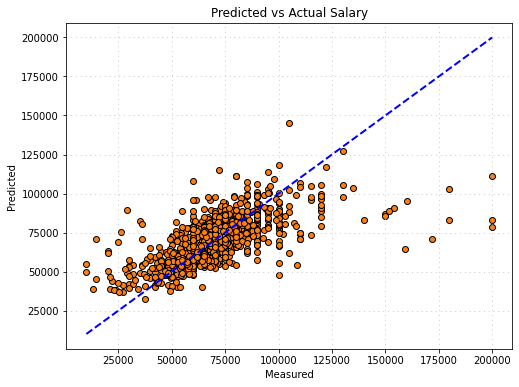

In [192]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('tweedie', TweedieRegressor(power=1.6, alpha=1, max_iter=3000))])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)

In [193]:
parameters = {'preprocess__cat_encode': [ce.polynomial.PolynomialEncoder(), ce.target_encoder.TargetEncoder(), ce.cat_boost.CatBoostEncoder(), ce.james_stein.JamesSteinEncoder(), ce.glmm.GLMMEncoder(), ce.backward_difference.BackwardDifferenceEncoder()],
             'kernelridge__alpha': np.logspace(-3, 3, 7), 'kernelridge__kernel': ['linear', 'polynomial', 'rbf', 'laplacian', 'chi2']}
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('cat_encode', ce.cat_boost.CatBoostEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('kernelridge', KernelRidge())])
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=2, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit=False)
_ = grid_search.fit(X_train, y_train)

In [194]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].nsmallest(10, 'rank_test_neg_mean_absolute_error')

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
108          PolynomialEncoder()                      -10871.427585   
96           PolynomialEncoder()                      -10886.435280   
72           PolynomialEncoder()                      -10895.445642   
66           PolynomialEncoder()                      -10938.926122   
101  BackwardDifferenceEncoder()                      -10941.395938   
78           PolynomialEncoder()                      -10941.835282   
77   BackwardDifferenceEncoder()                      -10990.113487   
83   BackwardDifferenceEncoder()                      -11008.092393   
102          PolynomialEncoder()                      -11041.544253   
113  BackwardDifferenceEncoder()                      -11077.648090   

     std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
108                       1072.945613                                  1   
96                        1061.192256                                  2   
72                        1032.928577                                  3   
66                         964.572190                                  4   
101                       1071.940141                                  5   
78                        1008.804106                                  6   
77                        1024.929018                                  7   
83                         980.100599                                  8   
102                       1036.683368                                  9   
113                       1090.067137                                 10   

     mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
108                     -2.903195e+08                     6.578540e+07   
96                      -2.844314e+08                     6.679673e+07   
72                      -2.733257e+08                     5.923290e+07   
66                      -2.767344e+08                     5.508214e+07   
101                     -2.908247e+08                     6.745960e+07   
78                      -2.742640e+08                     5.939485e+07   
77                      -2.799845e+08                     5.856004e+07   
83                      -2.802872e+08                     5.918263e+07   
102                     -2.957856e+08                     6.896081e+07   
113                     -3.028270e+08                     6.977412e+07   

     rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
108                                11      0.398912     0.077826            10  
96                                  7      0.411329     0.082924             7  
72                                  1      0.431966     0.074252             1  
66                                  3      0.423419     0.064332             3  
101                                13      0.398520     0.076258            11  
78                                  2      0.430192     0.070725             2  
77                                  5      0.418002     0.070031             4  
83                                  6      0.417723     0.068621             5  
102                                19      0.387923     0.088503            19  
113                                32      0.373752     0.078469            32

In [195]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].nsmallest(10, 'rank_test_neg_mean_squared_error')

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
72          PolynomialEncoder()                      -10895.445642   
78          PolynomialEncoder()                      -10941.835282   
66          PolynomialEncoder()                      -10938.926122   
42          PolynomialEncoder()                      -11221.106006   
77  BackwardDifferenceEncoder()                      -10990.113487   
83  BackwardDifferenceEncoder()                      -11008.092393   
96          PolynomialEncoder()                      -10886.435280   
71  BackwardDifferenceEncoder()                      -11085.743703   
95  BackwardDifferenceEncoder()                      -11312.589452   
90          PolynomialEncoder()                      -11367.031870   

    std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
72                       1032.928577                                  3   
78                       1008.804106                                  6   
66                        964.572190                                  4   
42                        945.368259                                 15   
77                       1024.929018                                  7   
83                        980.100599                                  8   
96                       1061.192256                                  2   
71                        971.447361                                 11   
95                       1118.910548                                 19   
90                       1147.314876                                 21   

    mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
72                     -2.733257e+08                     5.923290e+07   
78                     -2.742640e+08                     5.939485e+07   
66                     -2.767344e+08                     5.508214e+07   
42                     -2.799345e+08                     6.085170e+07   
77                     -2.799845e+08                     5.856004e+07   
83                     -2.802872e+08                     5.918263e+07   
96                     -2.844314e+08                     6.679673e+07   
71                     -2.861372e+08                     5.398774e+07   
95                     -2.887139e+08                     6.615601e+07   
90                     -2.893710e+08                     6.749111e+07   

    rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
72                                 1      0.431966     0.074252             1  
78                                 2      0.430192     0.070725             2  
66                                 3      0.423419     0.064332             3  
42                                 4      0.416196     0.081918             6  
77                                 5      0.418002     0.070031             4  
83                                 6      0.417723     0.068621             5  
96                                 7      0.411329     0.082924             7  
71                                 8      0.403184     0.062593             8  
95                                 9      0.399757     0.091839             9  
90                                10      0.398289     0.095488            12

In [196]:
pd.DataFrame(grid_search.cv_results_)[['param_preprocess__cat_encode', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].nsmallest(10, 'rank_test_r2')

param_preprocess__cat_encode  mean_test_neg_mean_absolute_error  \
72           PolynomialEncoder()                      -10895.445642   
78           PolynomialEncoder()                      -10941.835282   
66           PolynomialEncoder()                      -10938.926122   
77   BackwardDifferenceEncoder()                      -10990.113487   
83   BackwardDifferenceEncoder()                      -11008.092393   
42           PolynomialEncoder()                      -11221.106006   
96           PolynomialEncoder()                      -10886.435280   
71   BackwardDifferenceEncoder()                      -11085.743703   
95   BackwardDifferenceEncoder()                      -11312.589452   
108          PolynomialEncoder()                      -10871.427585   

     std_test_neg_mean_absolute_error  rank_test_neg_mean_absolute_error  \
72                        1032.928577                                  3   
78                        1008.804106                                  6   
66                         964.572190                                  4   
77                        1024.929018                                  7   
83                         980.100599                                  8   
42                         945.368259                                 15   
96                        1061.192256                                  2   
71                         971.447361                                 11   
95                        1118.910548                                 19   
108                       1072.945613                                  1   

     mean_test_neg_mean_squared_error  std_test_neg_mean_squared_error  \
72                      -2.733257e+08                     5.923290e+07   
78                      -2.742640e+08                     5.939485e+07   
66                      -2.767344e+08                     5.508214e+07   
77                      -2.799845e+08                     5.856004e+07   
83                      -2.802872e+08                     5.918263e+07   
42                      -2.799345e+08                     6.085170e+07   
96                      -2.844314e+08                     6.679673e+07   
71                      -2.861372e+08                     5.398774e+07   
95                      -2.887139e+08                     6.615601e+07   
108                     -2.903195e+08                     6.578540e+07   

     rank_test_neg_mean_squared_error  mean_test_r2  std_test_r2  rank_test_r2  
72                                  1      0.431966     0.074252             1  
78                                  2      0.430192     0.070725             2  
66                                  3      0.423419     0.064332             3  
77                                  5      0.418002     0.070031             4  
83                                  6      0.417723     0.068621             5  
42                                  4      0.416196     0.081918             6  
96                                  7      0.411329     0.082924             7  
71                                  8      0.403184     0.062593             8  
95                                  9      0.399757     0.091839             9  
108                                11      0.398912     0.077826            10

In [197]:
pd.DataFrame(grid_search.cv_results_).loc[72, 'params']

{'kernelridge__alpha': 0.1,
 'kernelridge__kernel': 'rbf',
 'preprocess__cat_encode': PolynomialEncoder()}

In [126]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('krreg', KernelRidge(alpha=0.1, kernel='rbf'))])
cross_val_score(pipe, X_train, y_train, cv=10)

array([0.43634757, 0.33002411, 0.47173179, 0.42312131, 0.41059562,
       0.469041  , 0.5918532 , 0.31255132, 0.46321056, 0.41118509])

Mean Squared Error: 273258056.85822535
Mean Absolute Error: 10894.175594588001


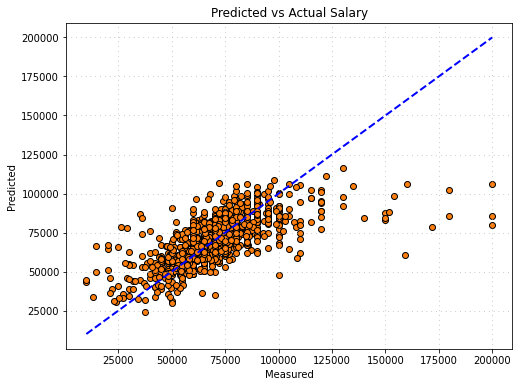

In [127]:
preprocessors = ColumnTransformer([('scaler', StandardScaler(), num_feats), ('poly_encode', ce.polynomial.PolynomialEncoder(), cat_feats)])
pipe = Pipeline([('preprocess', preprocessors), ('krreg', KernelRidge(alpha=0.1, kernel='rbf'))])
ypred = cross_val_predict(pipe, X_train, y_train, cv=10)
scatter_plot(y_train, ypred)